In [1]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def step_to_block(step, block_size=32, block_id_base=1):
    block_idx0 = step // block_size        # 0..num_blocks-1
    step_block = step % block_size         # 0..block_size-1
    block_id = block_idx0 + block_id_base
    return block_id, step_block

def load_kv_tensor(path):
    obj = torch.load(path, map_location="cpu")
    if torch.is_tensor(obj):
        return obj
    if isinstance(obj, dict):
        for key in ["k", "v", "key", "value", "K", "V"]:
            if key in obj and torch.is_tensor(obj[key]):
                return obj[key]
    raise TypeError(f"Unrecognized content in {path}: {type(obj)}")

def load_step_tensor(records_dir, sample_id, layer, kind, step,
                     block_size=32, block_id_base=1):
    block_id, step_block = step_to_block(step, block_size, block_id_base)
    fname = f"batch_{sample_id}_{block_id}_{step_block}_{layer}_{kind}_previous.pt"
    fpath = os.path.join(records_dir, fname)
    if not os.path.exists(fpath):
        raise FileNotFoundError(f"Missing file: {fpath}")
    T = load_kv_tensor(fpath)

    # Expect [seq, hidden]. If you have [1, seq, hidden], squeeze batch dim.
    if T.ndim == 3 and T.shape[0] == 1:
        T = T[0]

    if T.ndim != 2:
        raise ValueError(f"Expected 2D [seq, hidden], got shape {tuple(T.shape)} in {fpath}")

    return T.detach().float()  # float32 on CPU

def neighbor_step_similarity_heatmap(records_dir, sample_id, layer, kind="k",
                                     total_steps=128, block_size=32, block_id_base=1):
    prev = load_step_tensor(records_dir, sample_id, layer, kind, step=0,
                            block_size=block_size, block_id_base=block_id_base)
    seq_len, hidden = prev.shape

    sims = torch.empty((total_steps - 1, seq_len), dtype=torch.float32)  # [steps-1, seq]

    for step in range(1, total_steps):
        cur = load_step_tensor(records_dir, sample_id, layer, kind, step,
                               block_size=block_size, block_id_base=block_id_base)

        if cur.shape != prev.shape:
            raise ValueError(f"Shape mismatch at step {step}: {cur.shape} vs {prev.shape}")

        # cosine similarity per token position (dim=hidden)
        sims[step - 1] = F.cosine_similarity(cur, prev, dim=1, eps=1e-8)
        prev = cur

    return sims  # [total_steps-1, seq_len], values in [-1, 1]

def plot_token_vs_neighborstep_heatmap(sims, title="", savepath=None, vmin=-1.0, vmax=1.0):
    plt.figure(figsize=(10, 6), dpi=150)
    im = plt.imshow(sims.numpy(), aspect="auto", cmap="RdYlGn", vmin=vmin, vmax=vmax)
    plt.colorbar(im, fraction=0.046, pad=0.04, label="cosine similarity")

    plt.xlabel("token position")
    plt.ylabel("step n (compared to step n-1)")
    plt.title(title)

    # y row 0 corresponds to step 1 vs 0, so show y ticks as real step numbers
    # (optional: keep it light for 128 steps)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show()


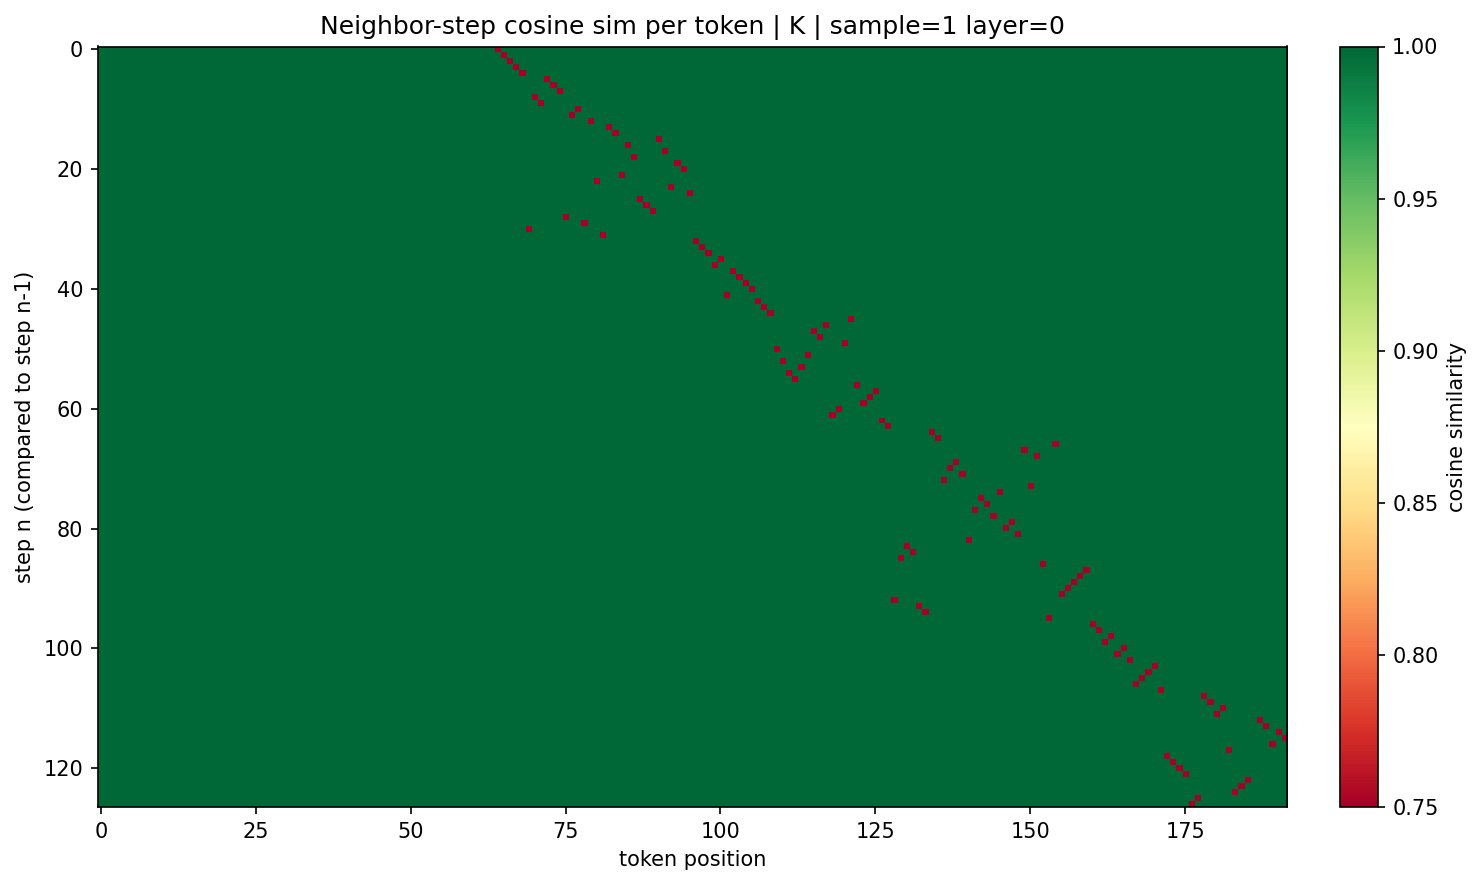

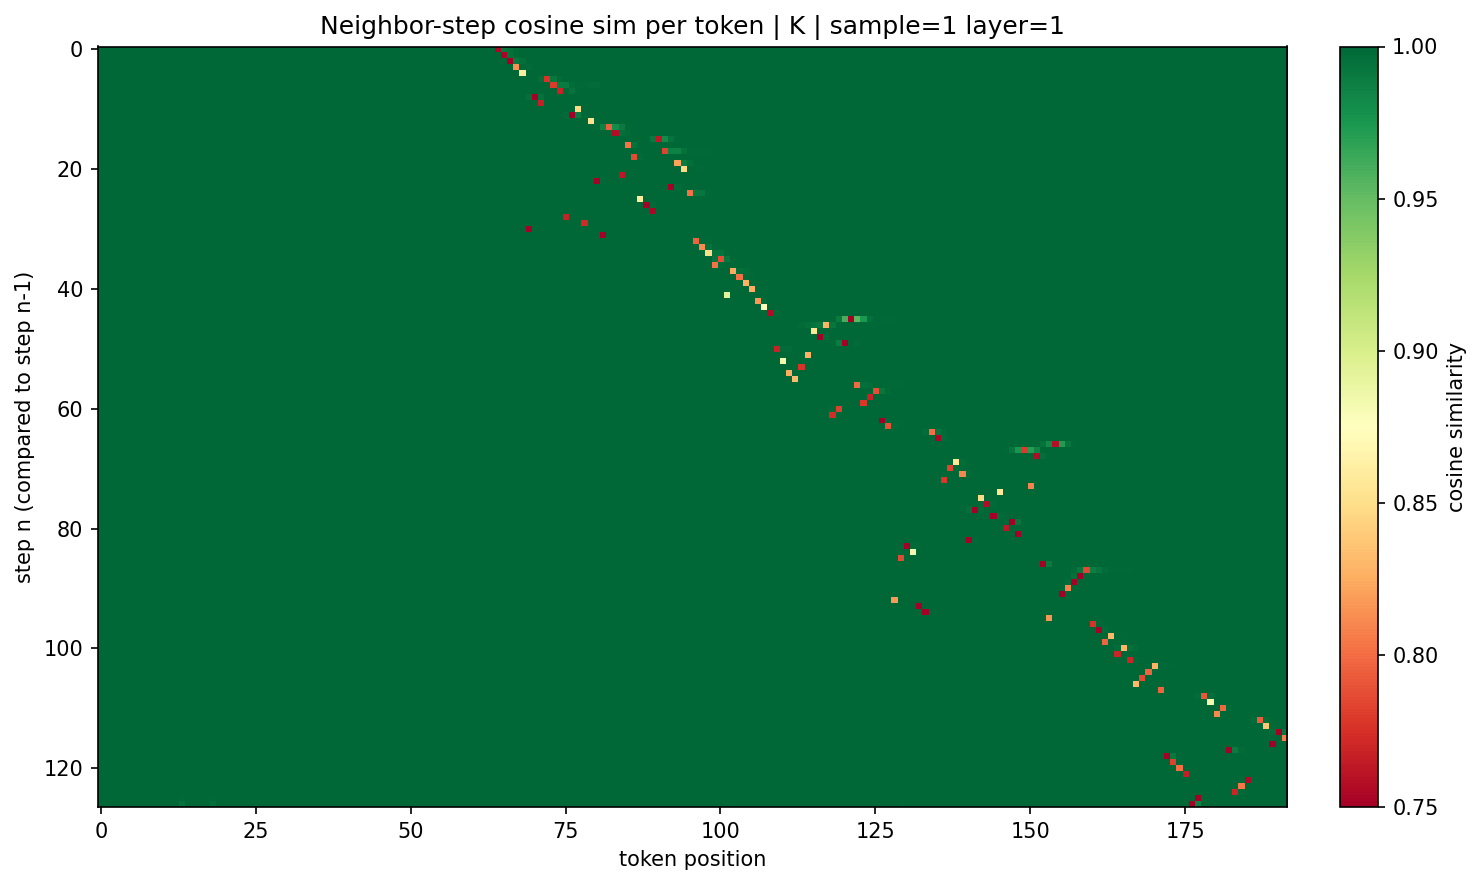

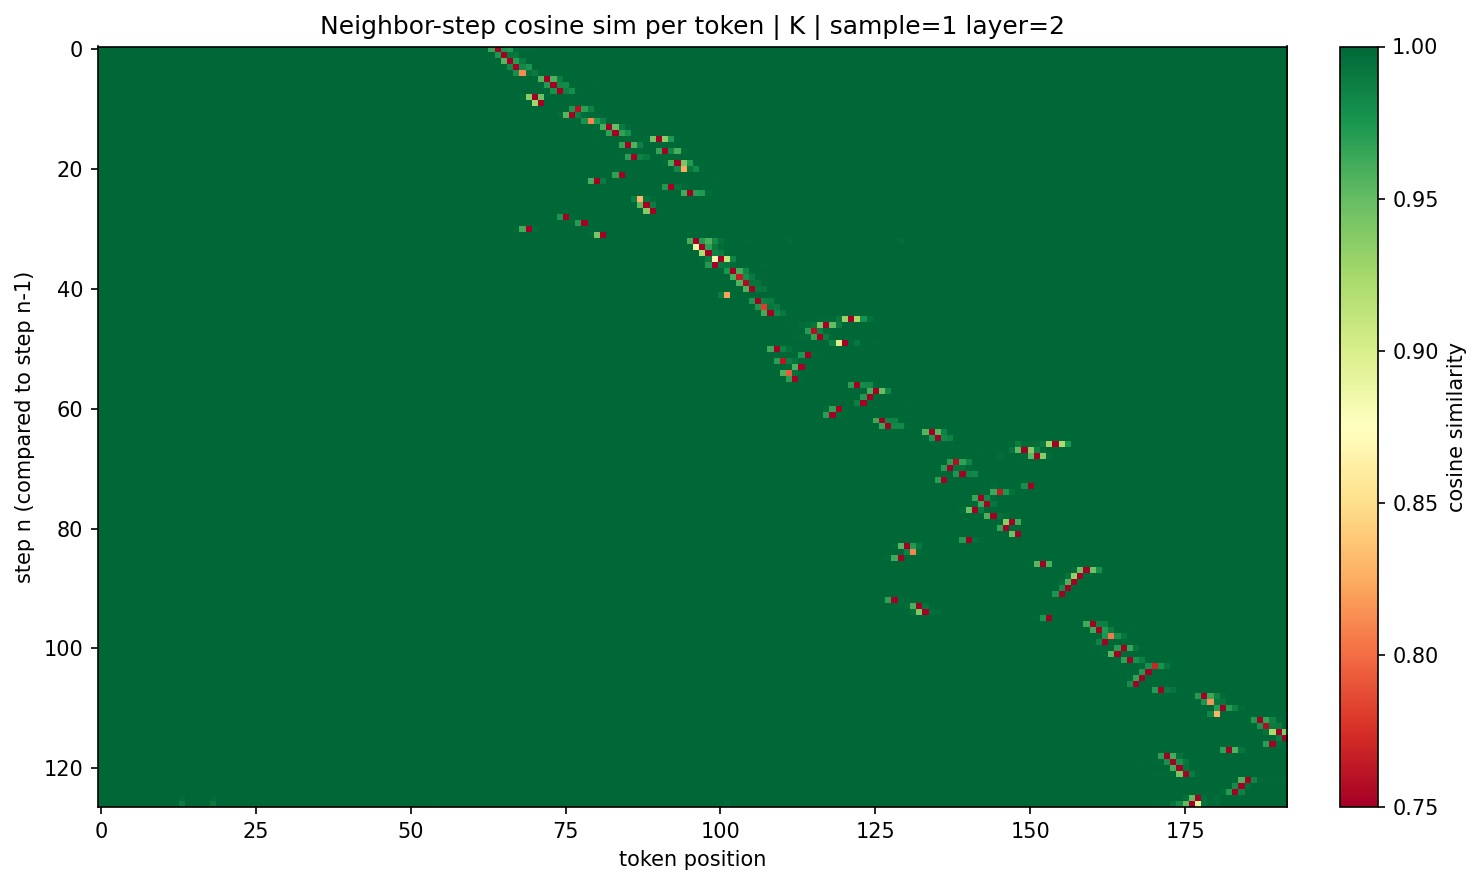

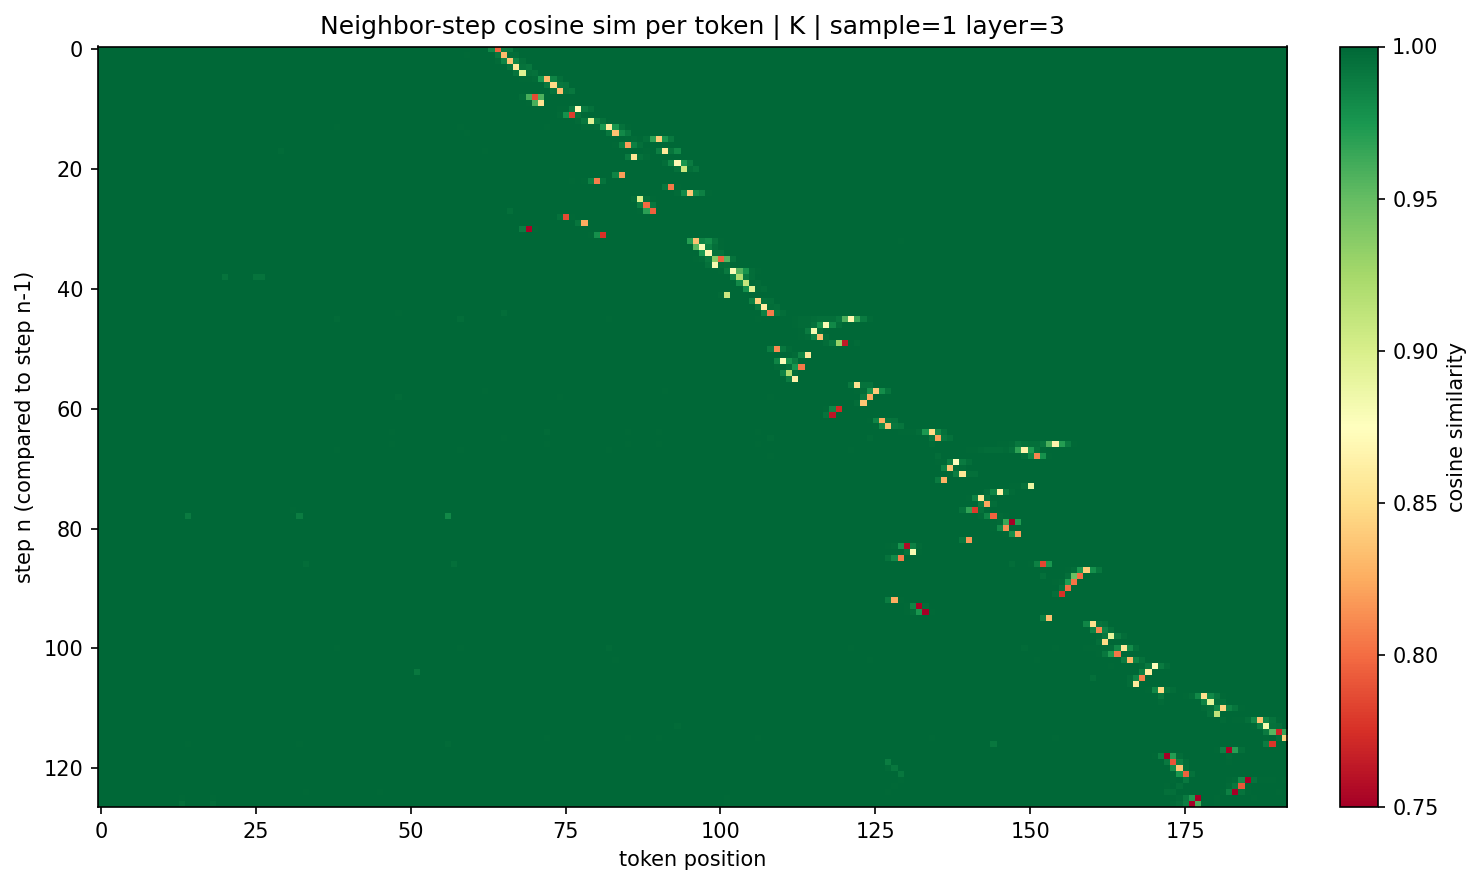

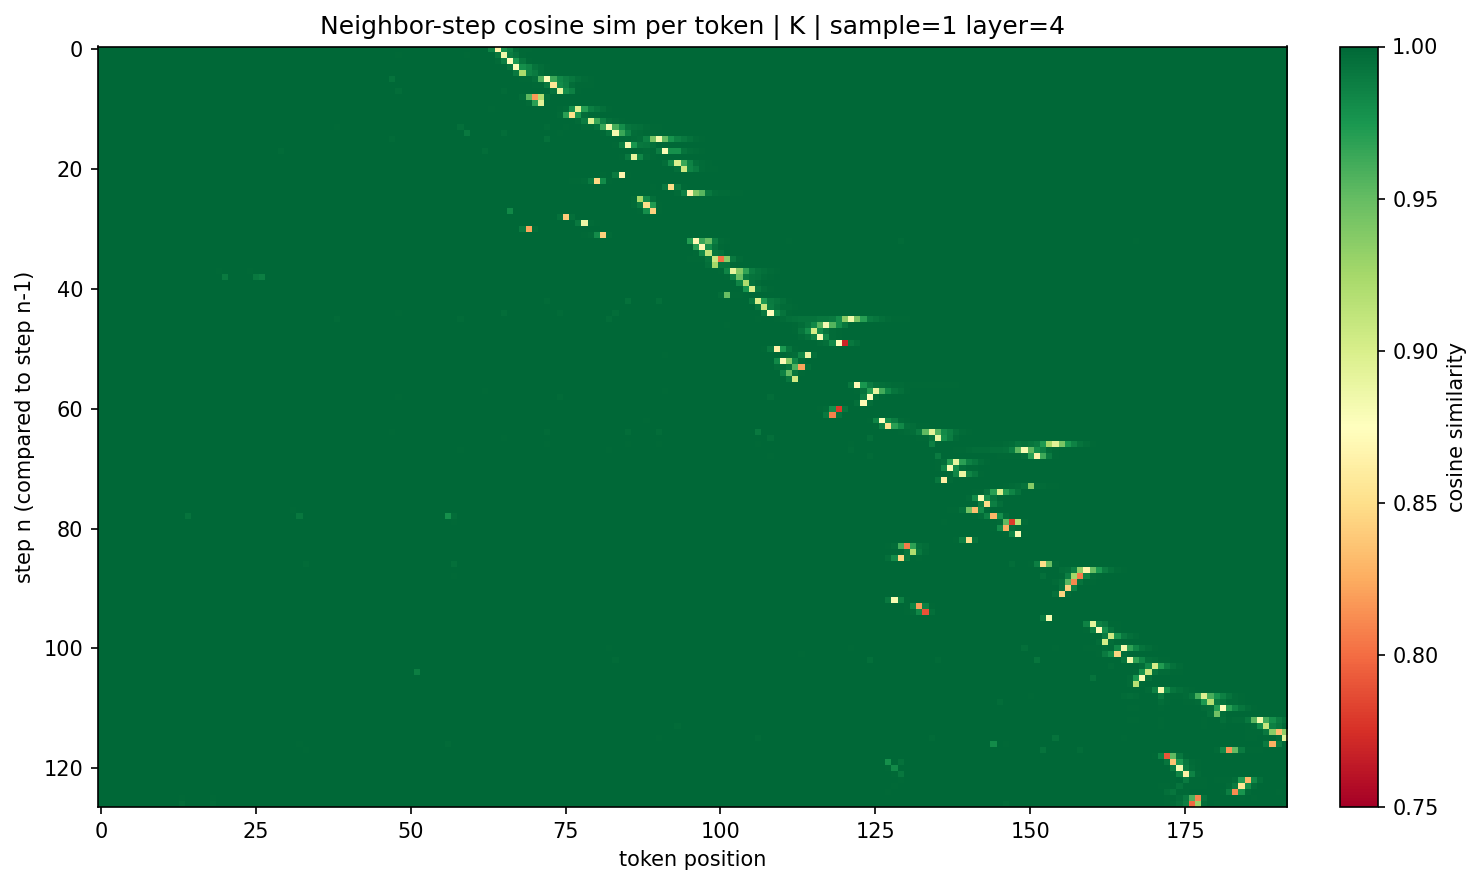

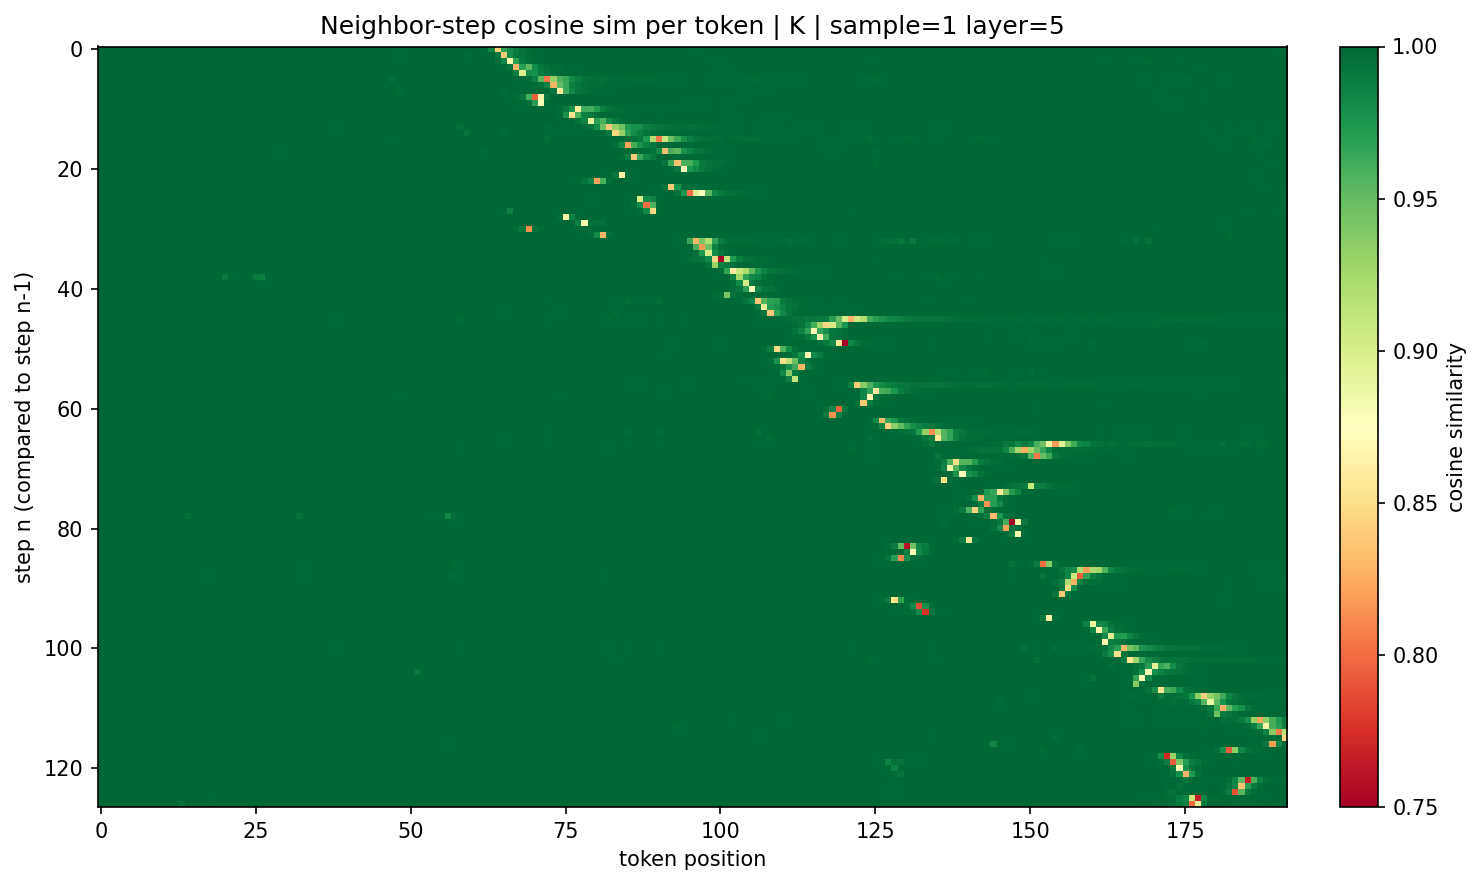

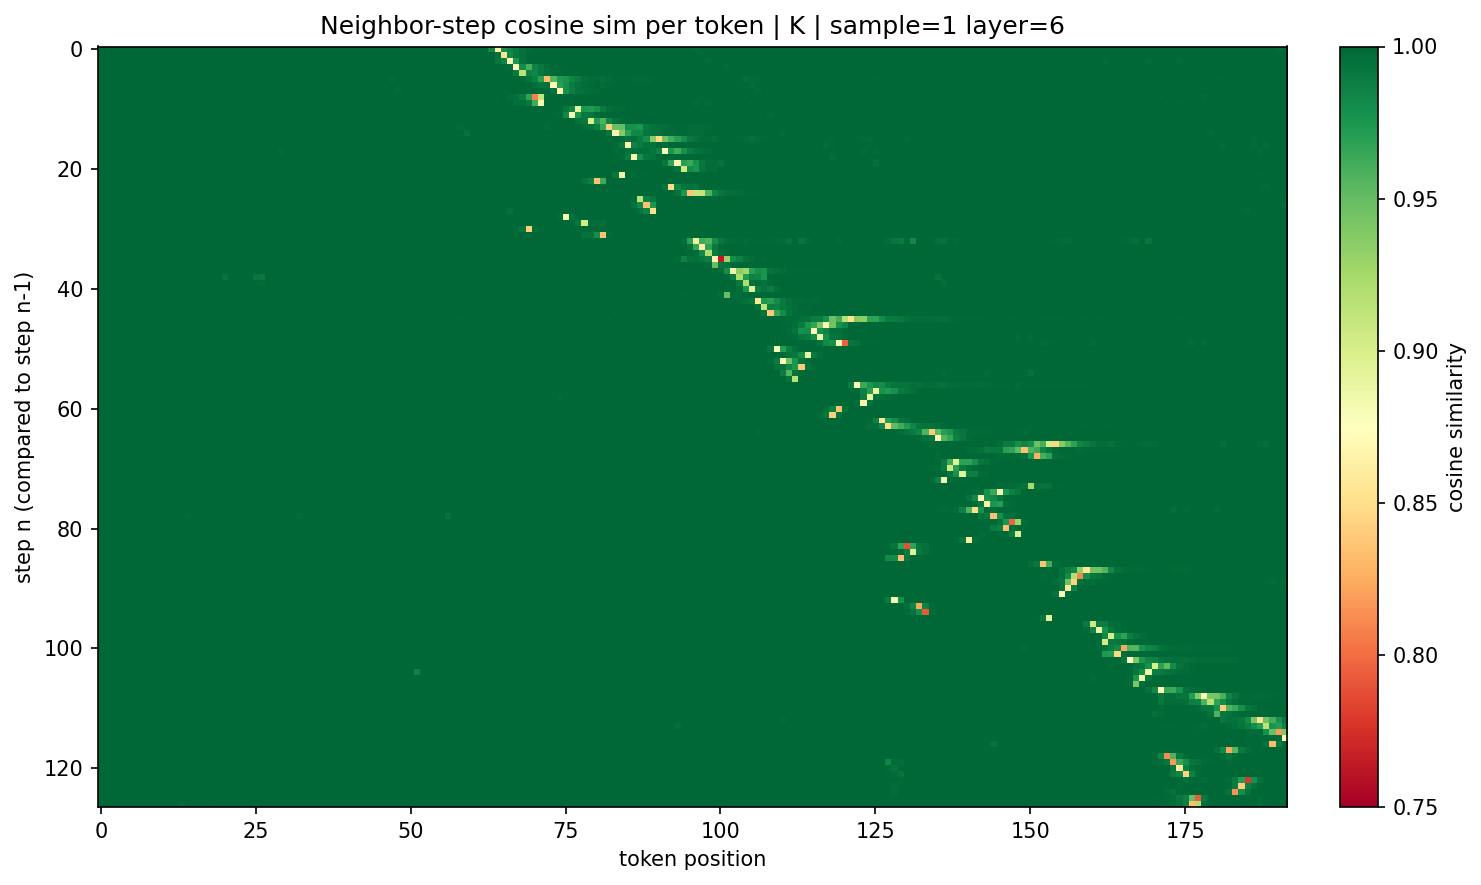

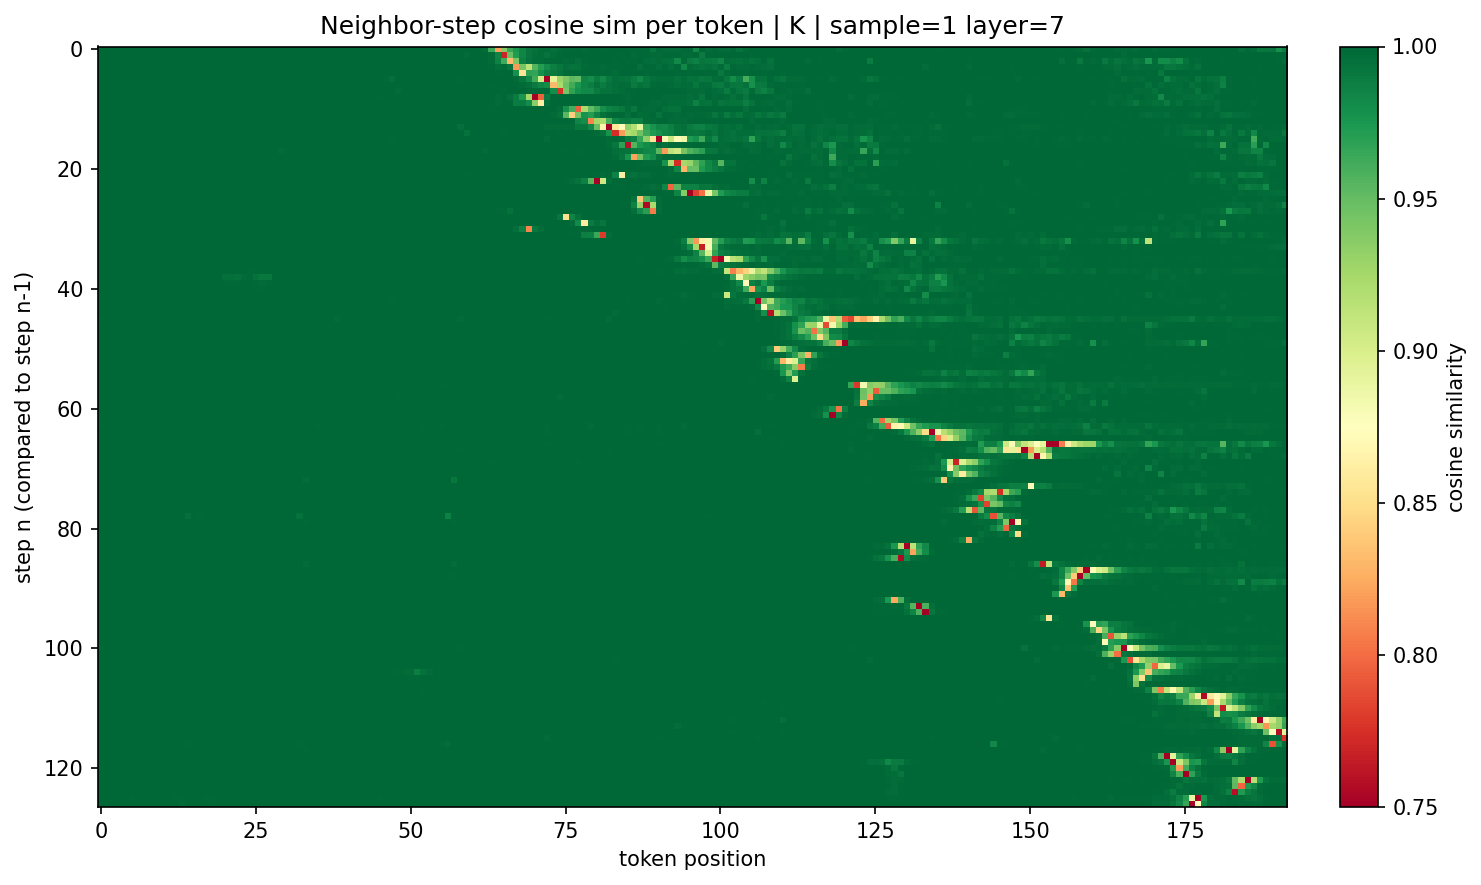

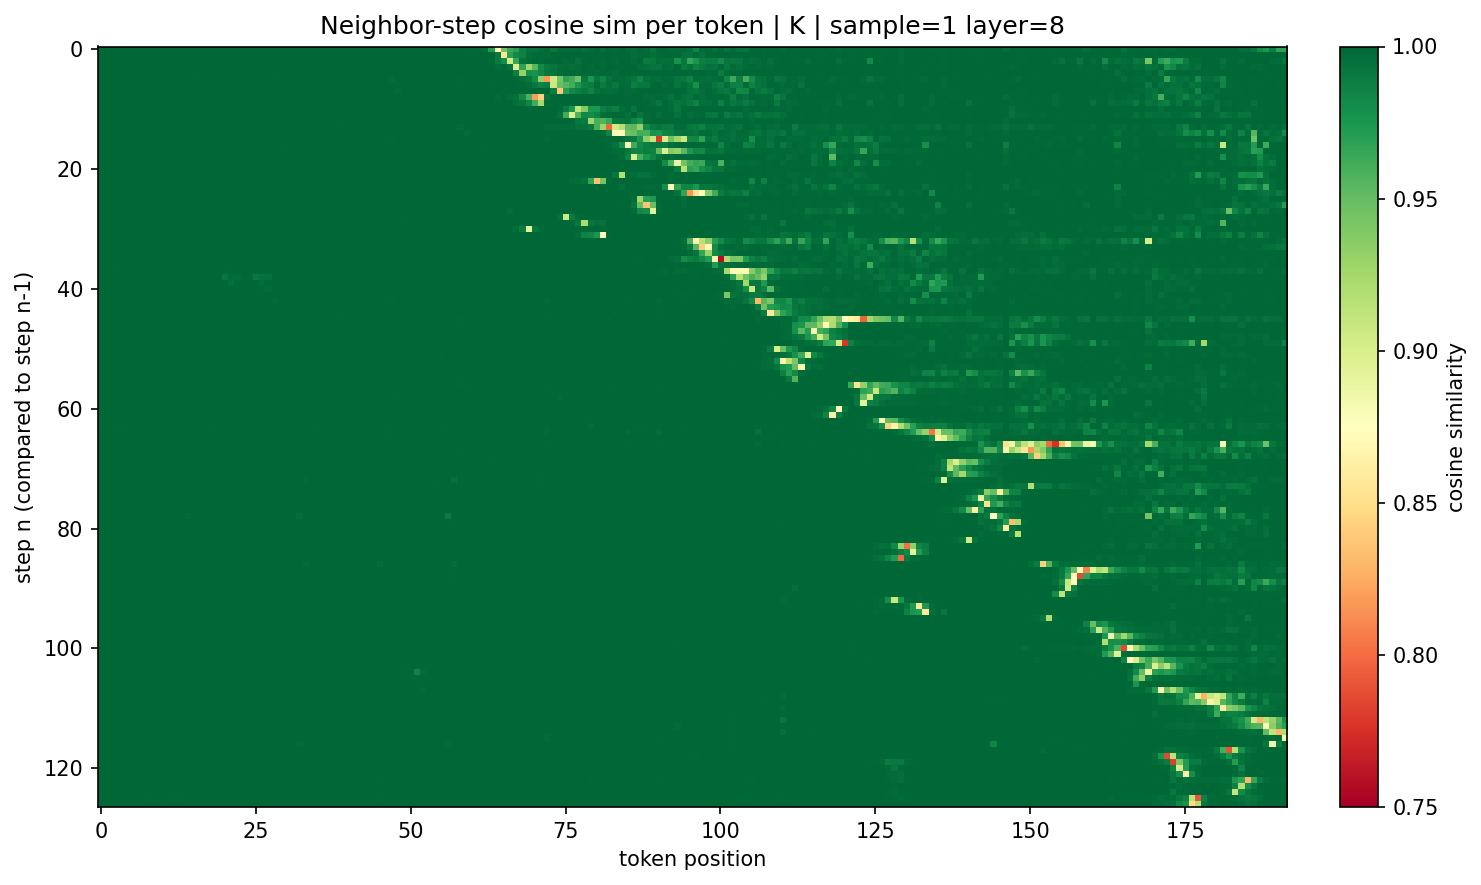

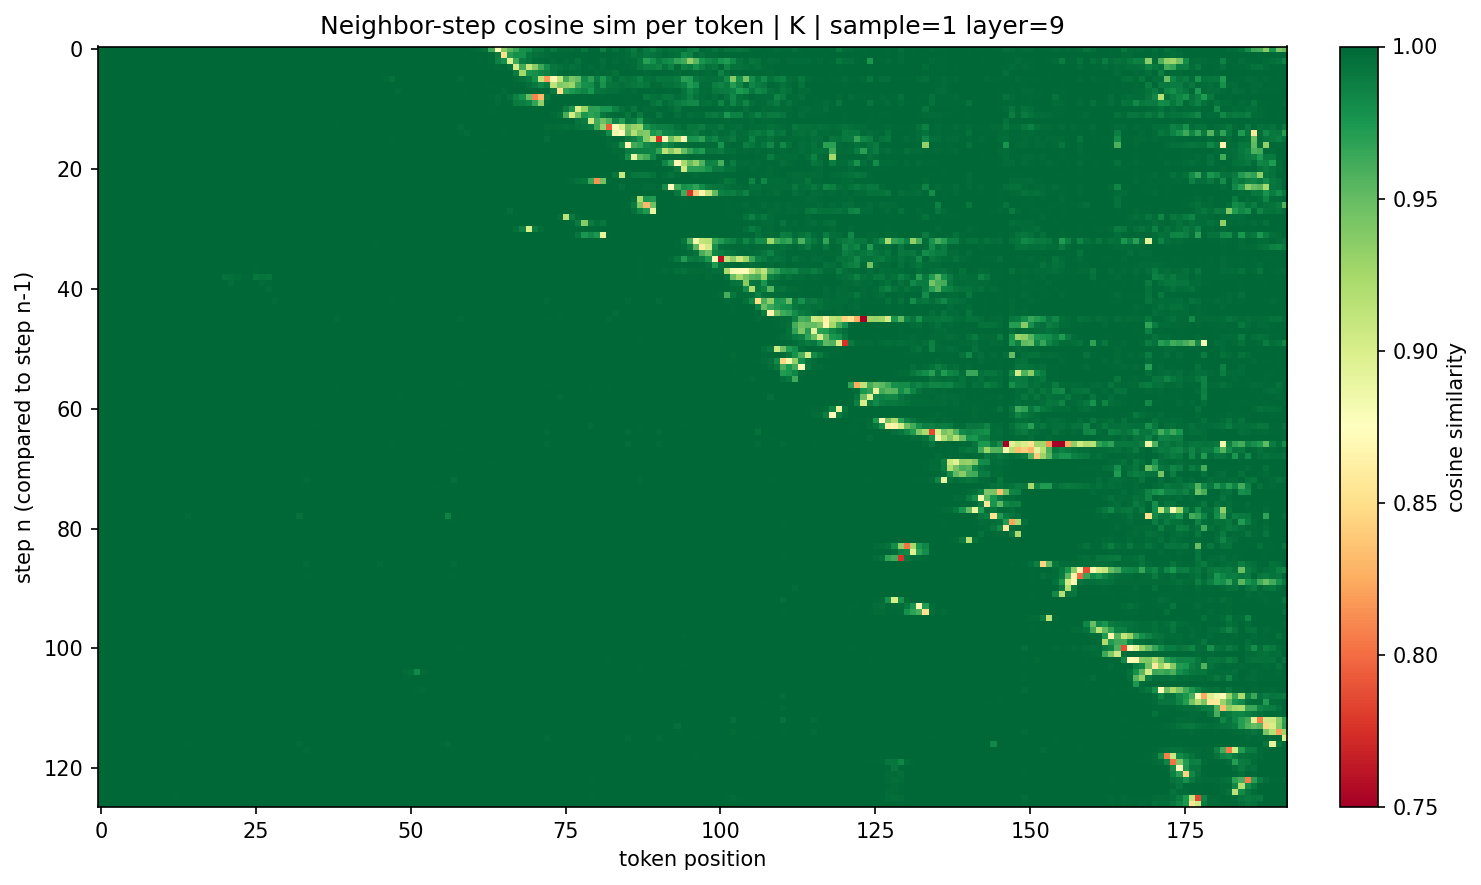

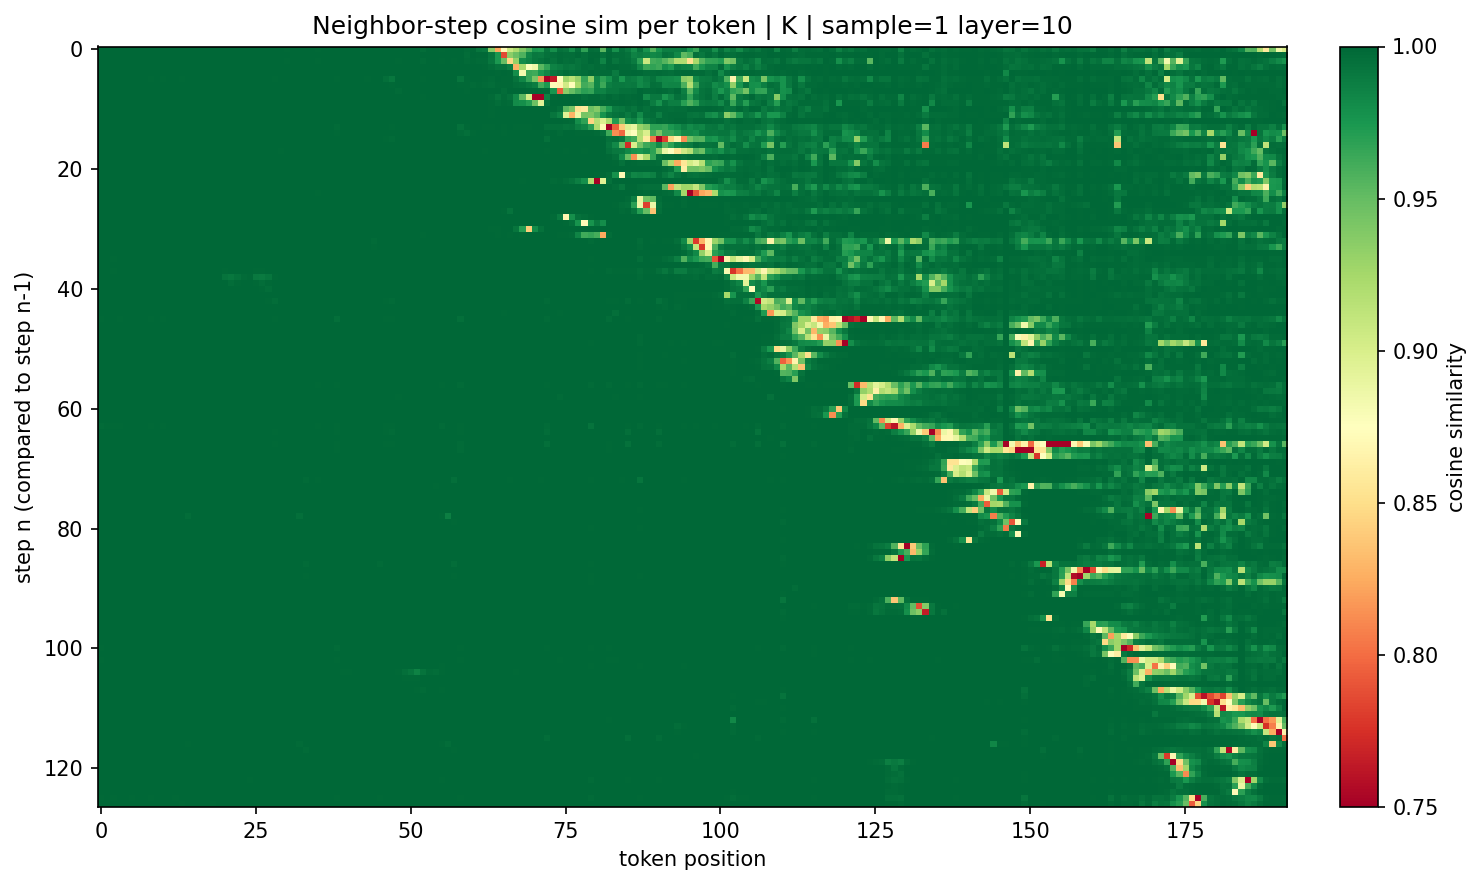

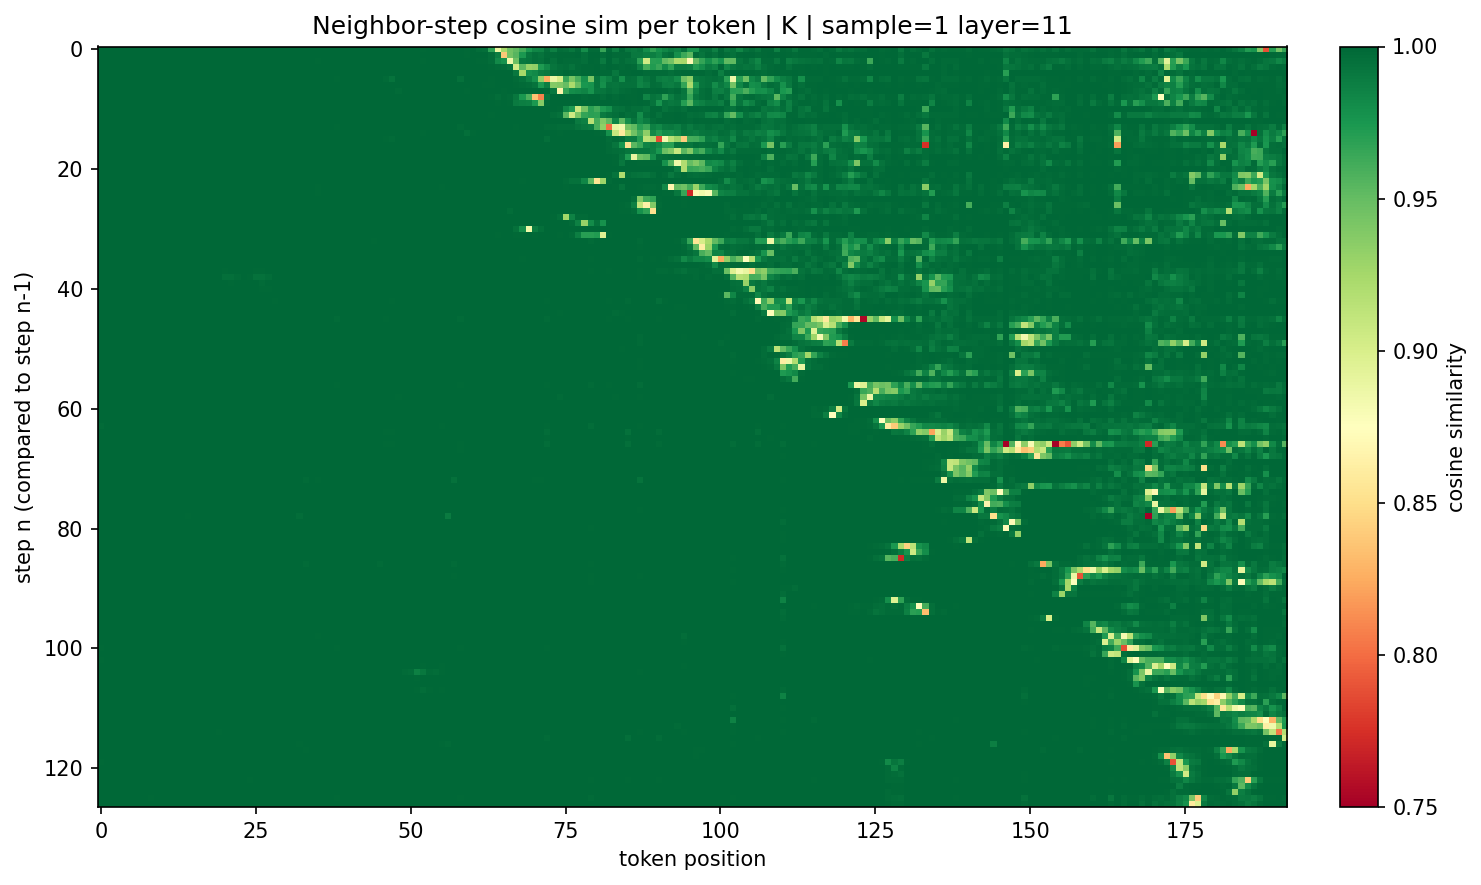

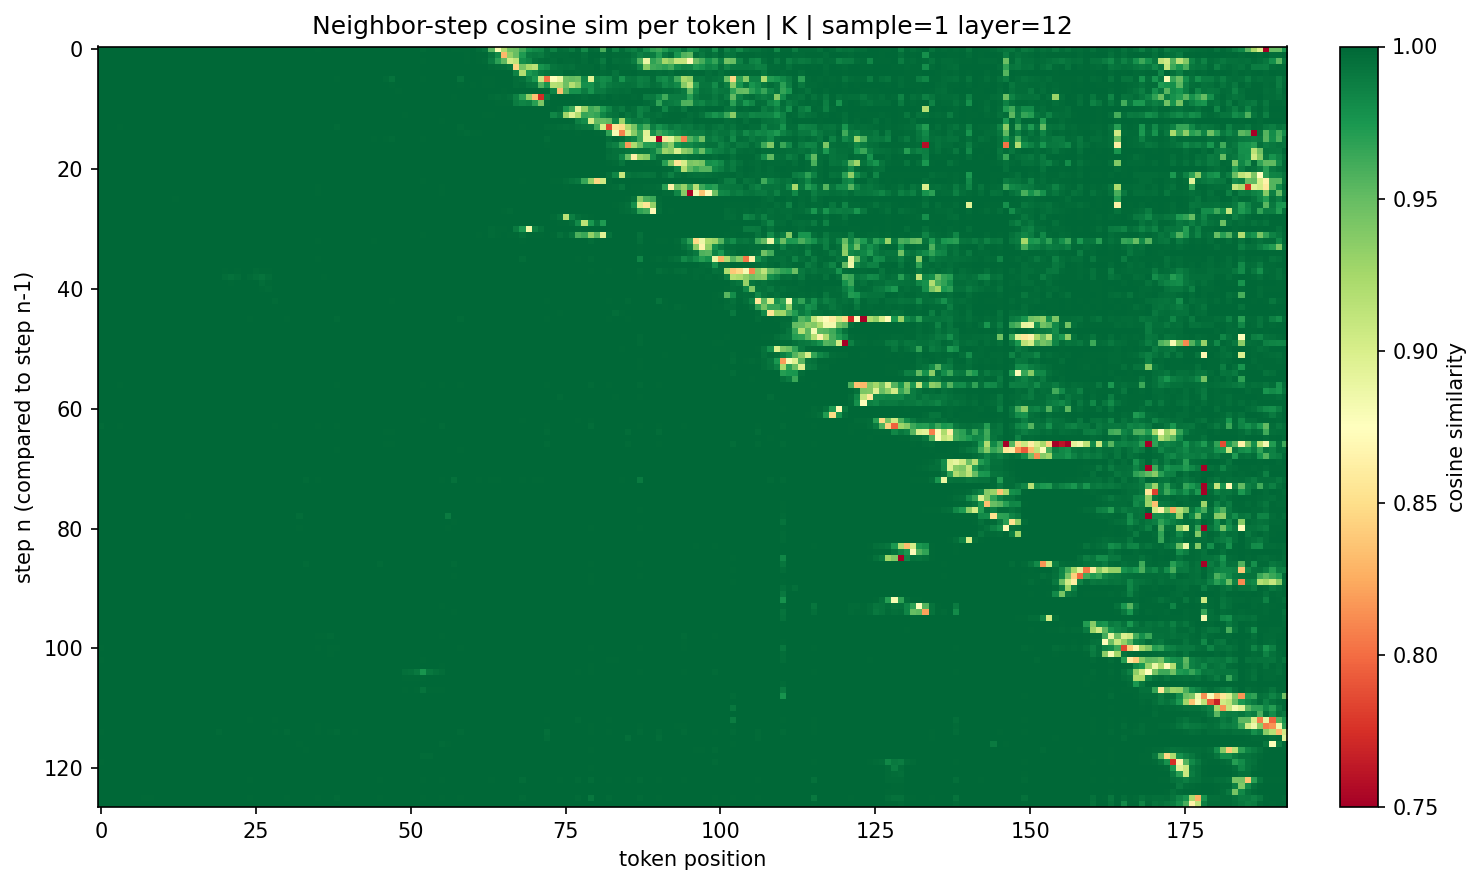

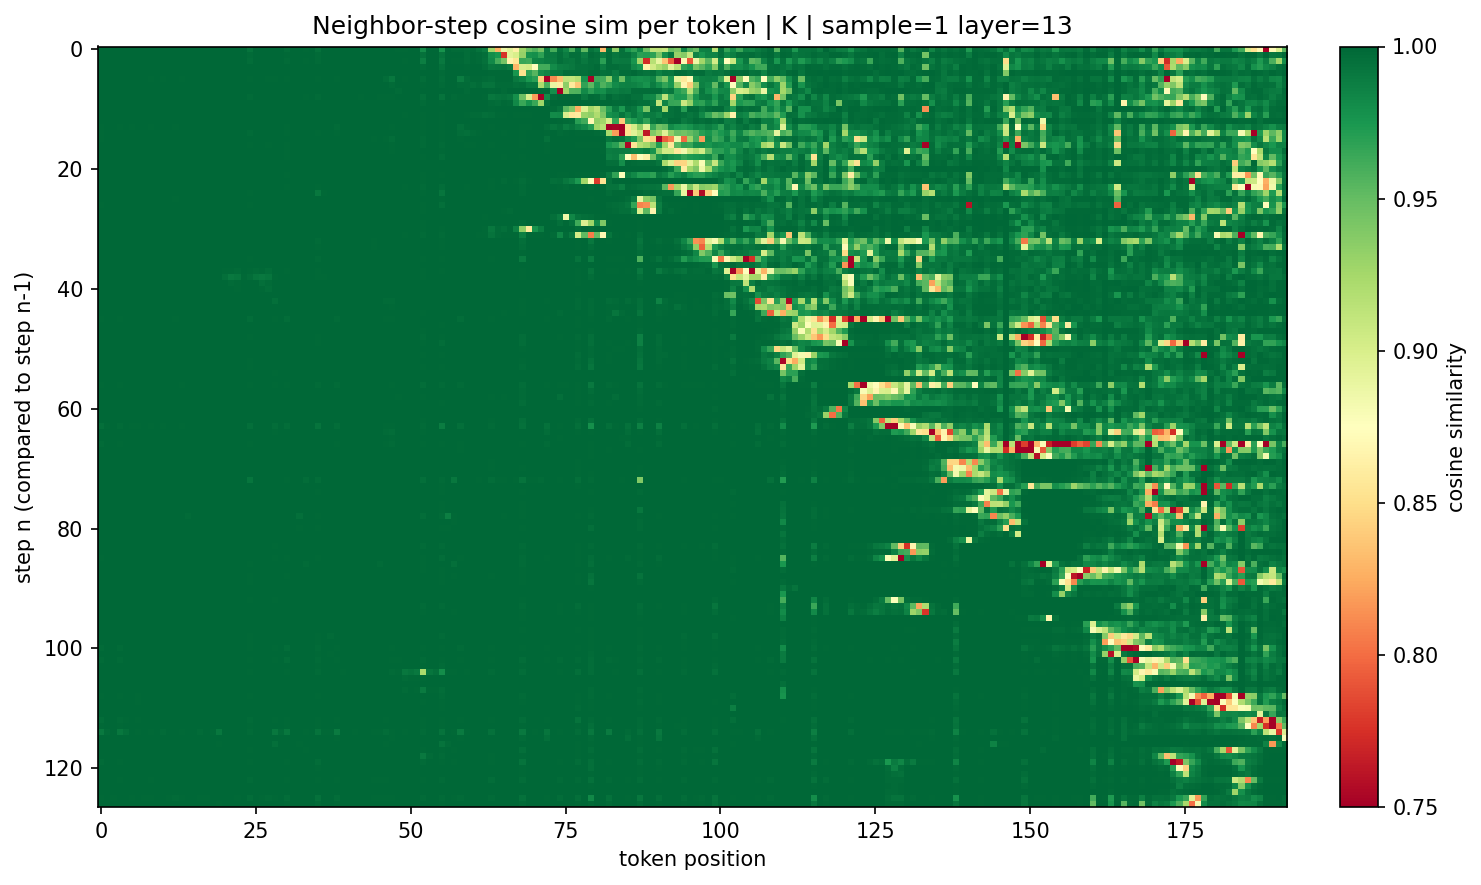

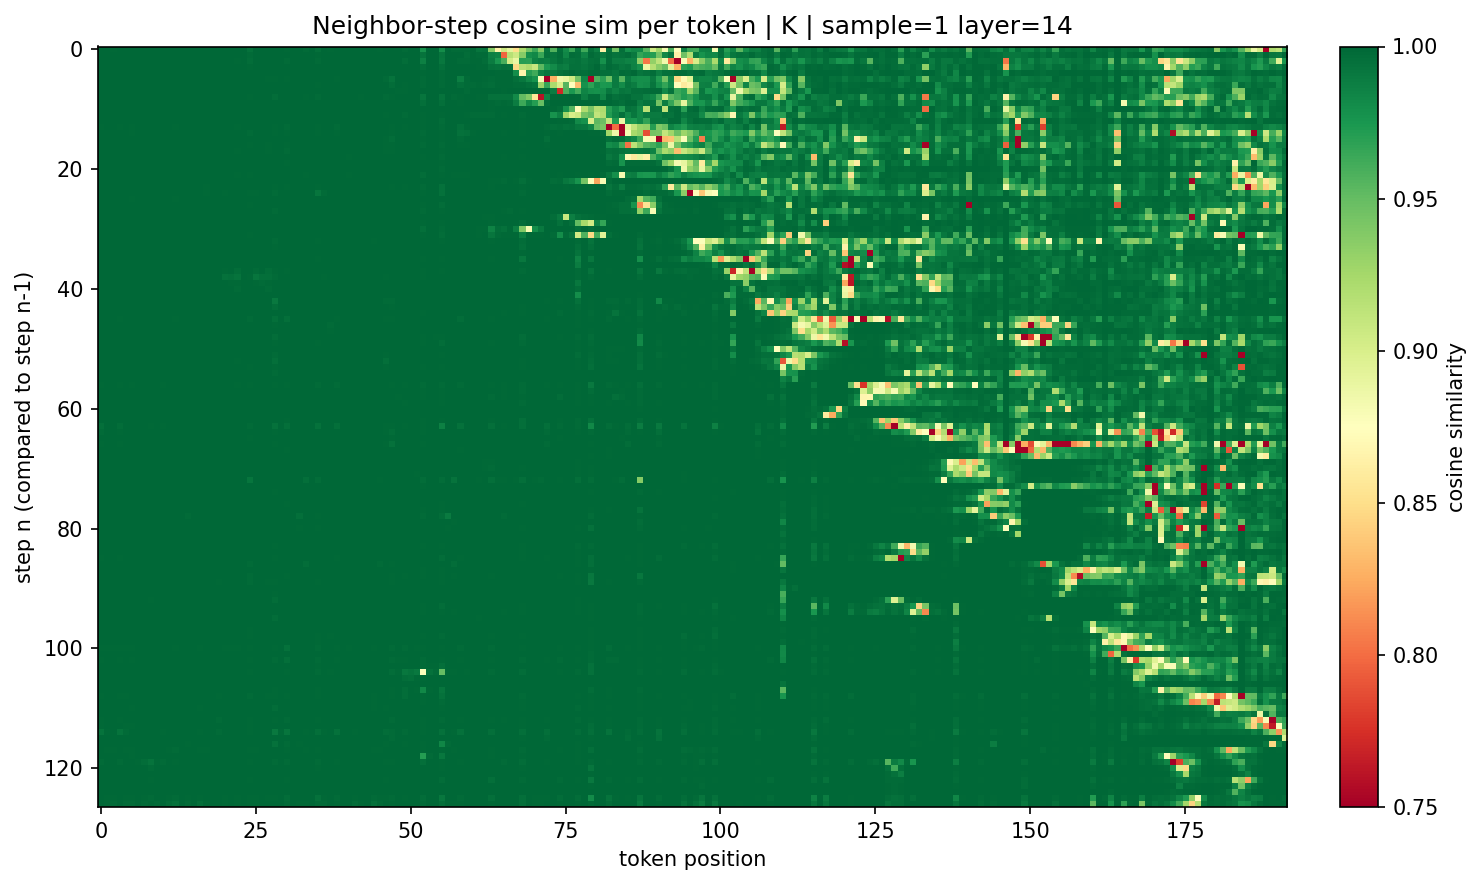

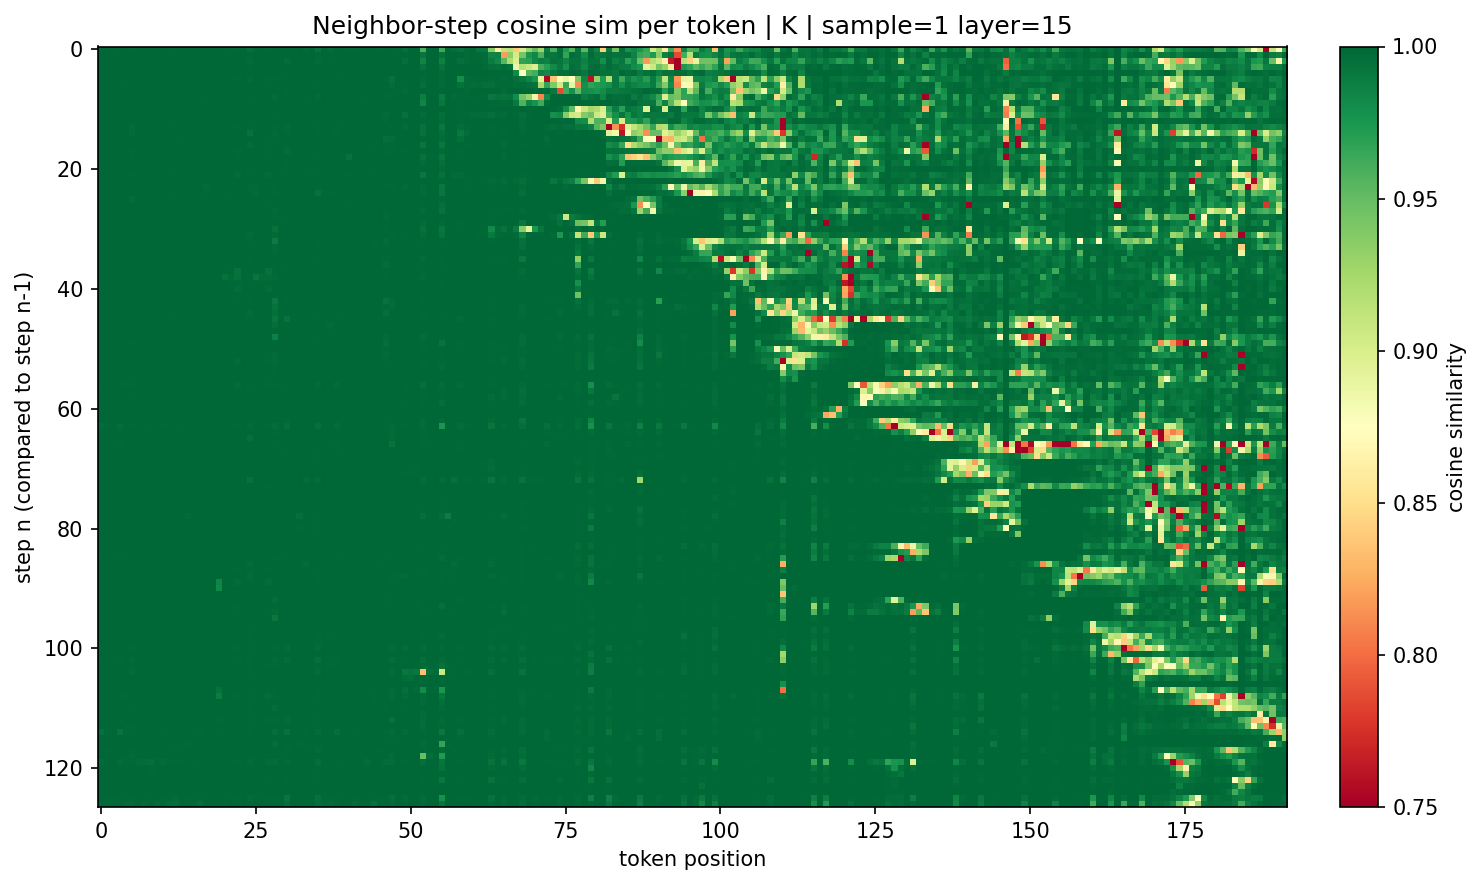

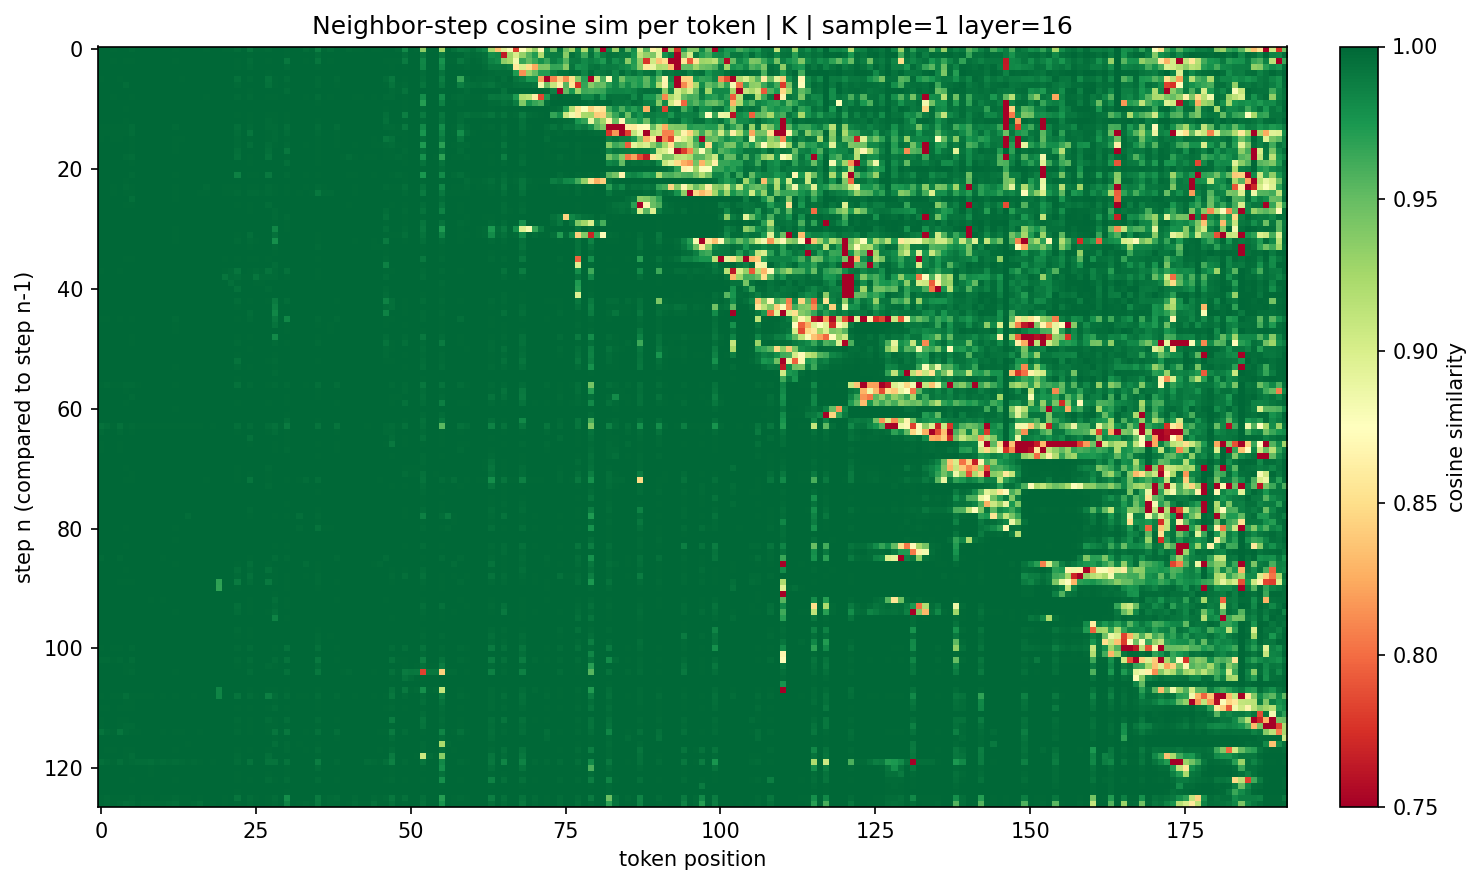

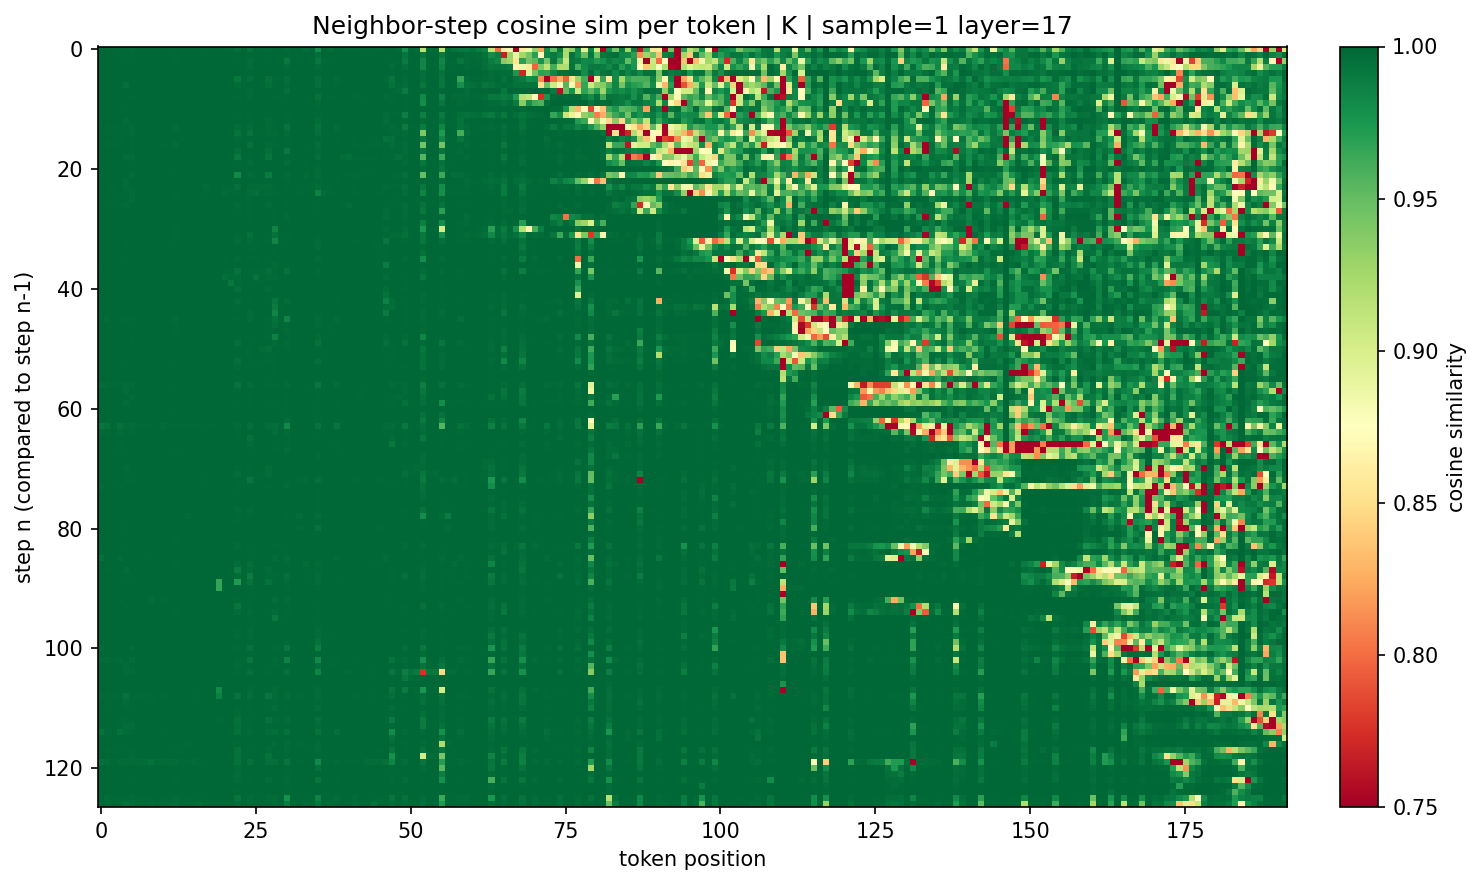

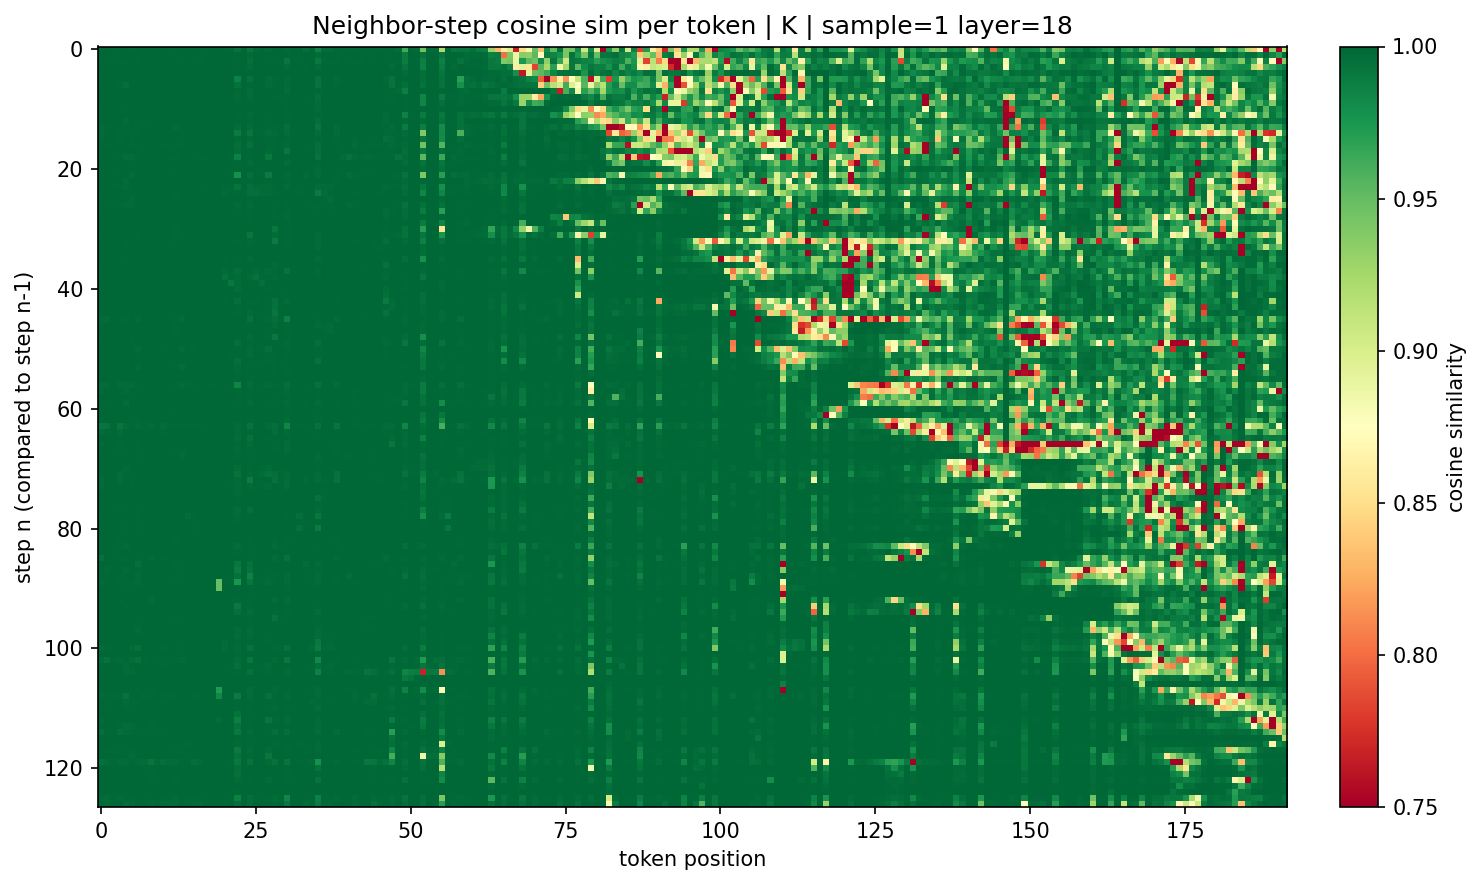

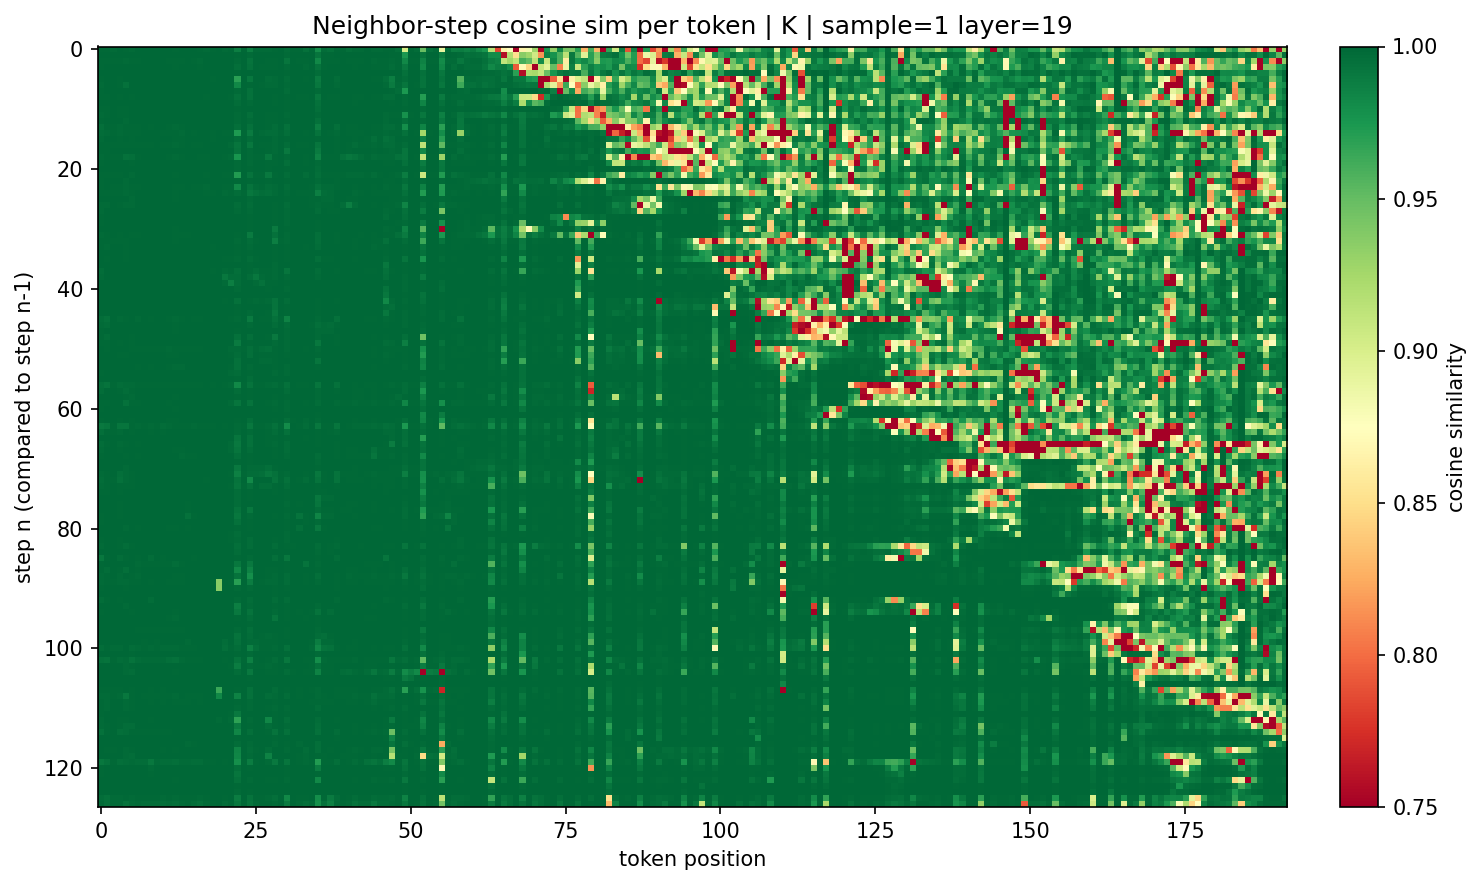

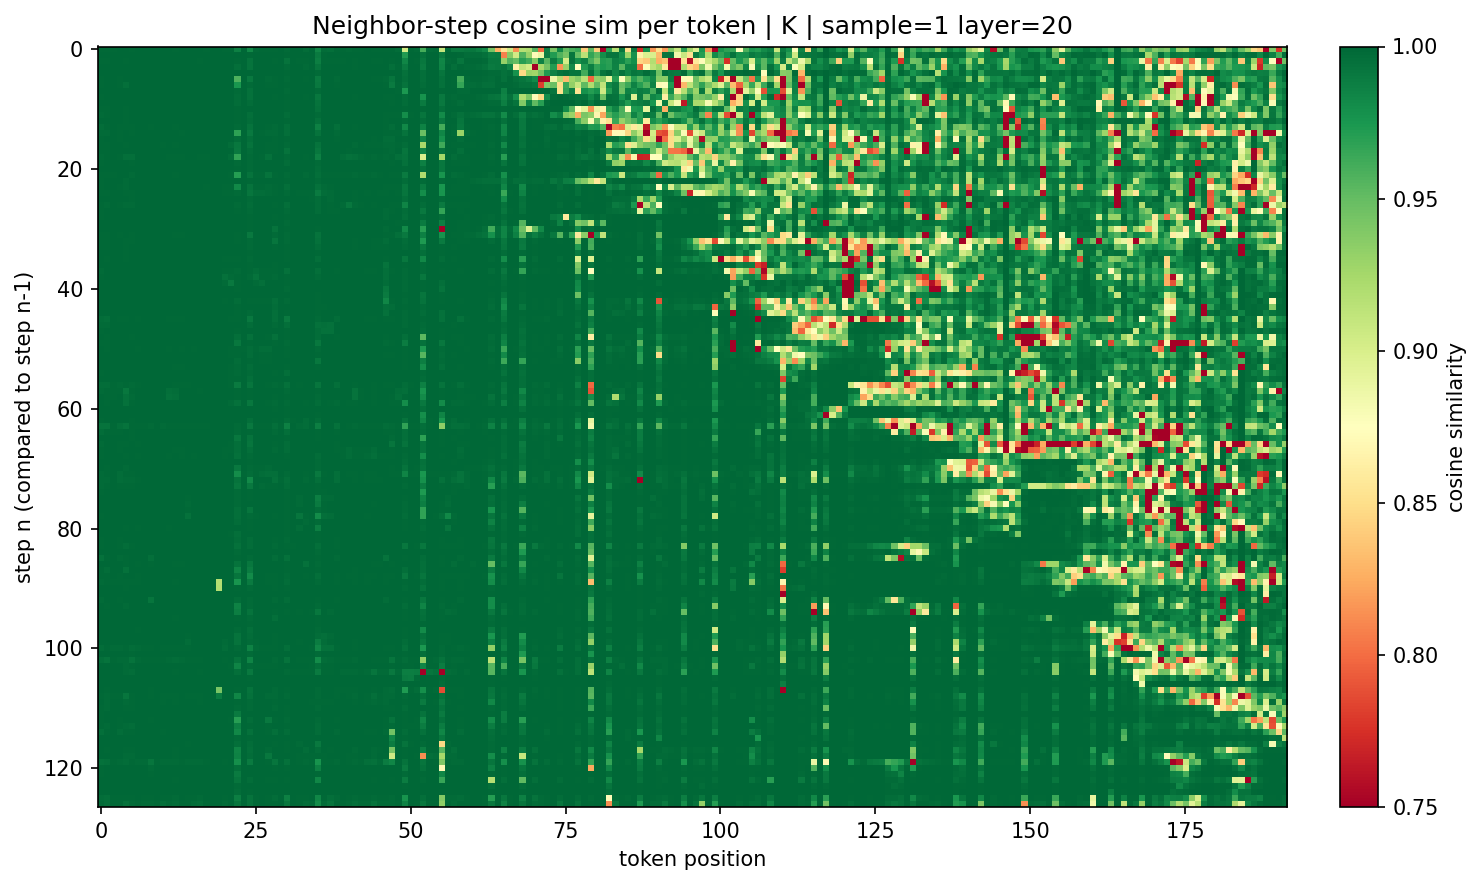

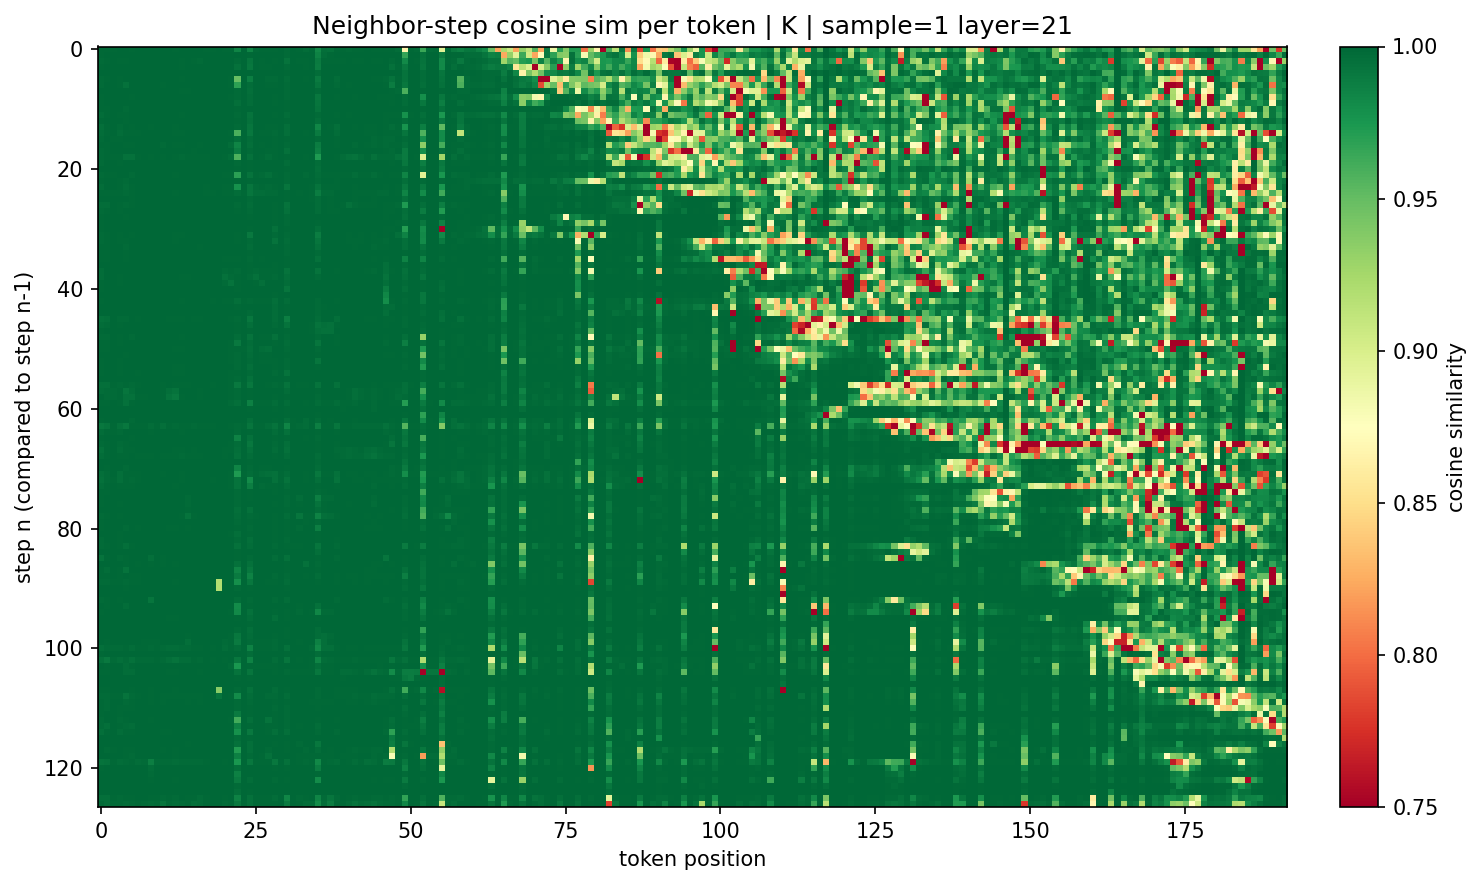

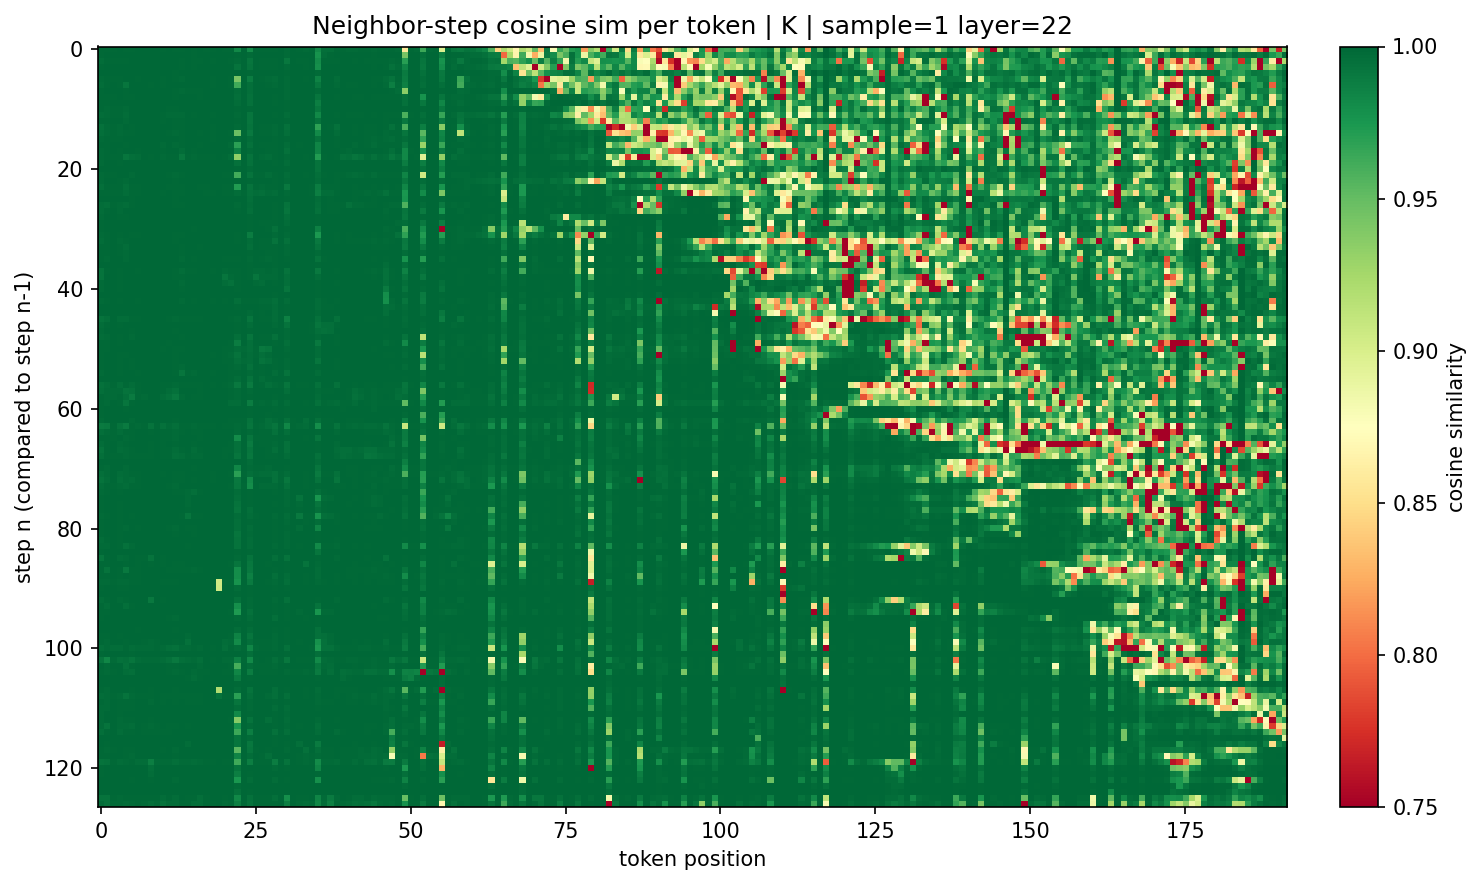

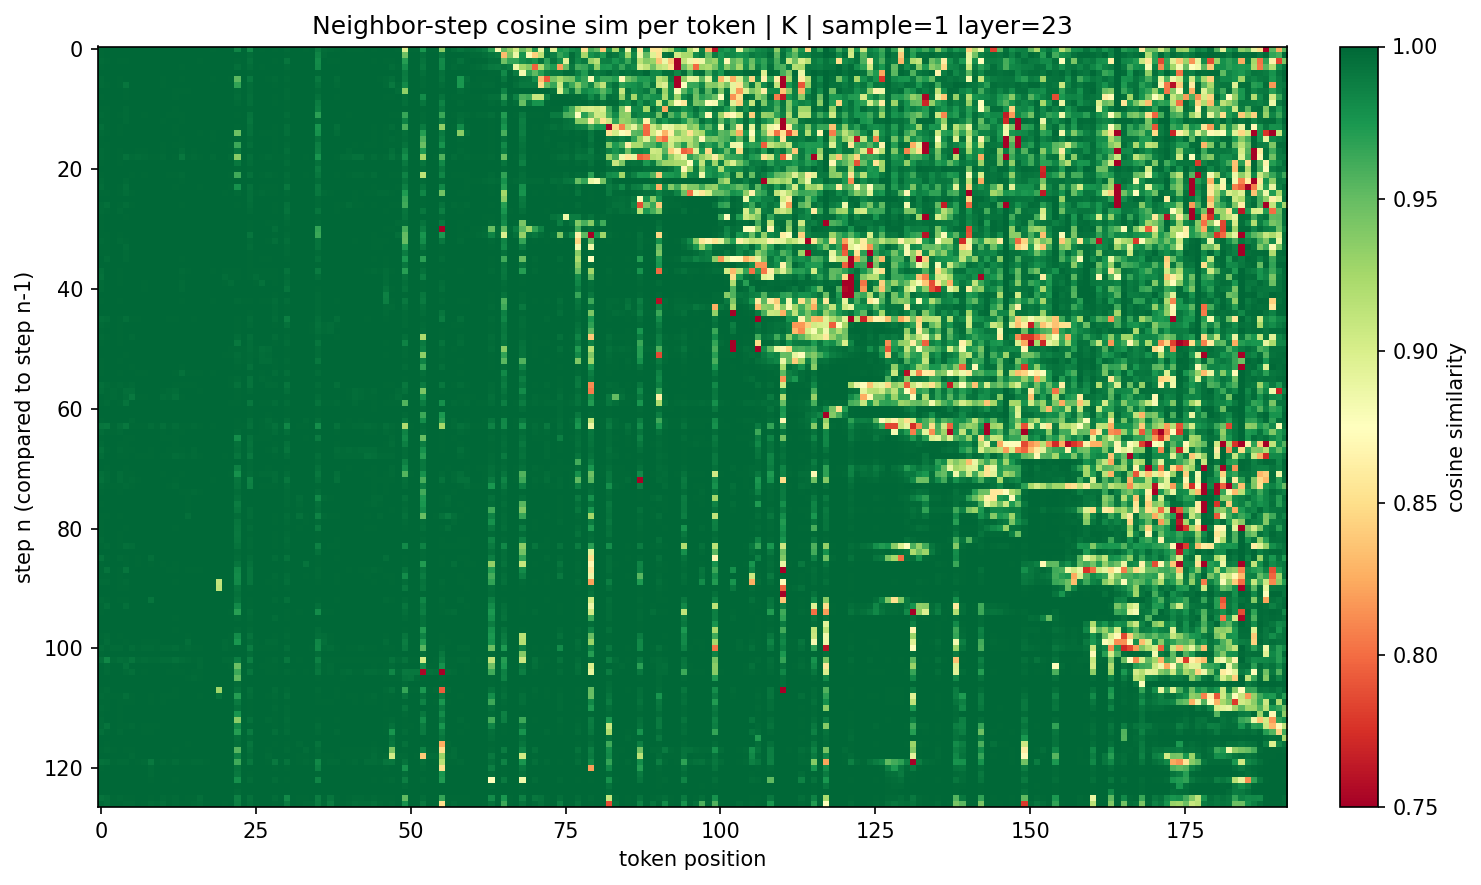

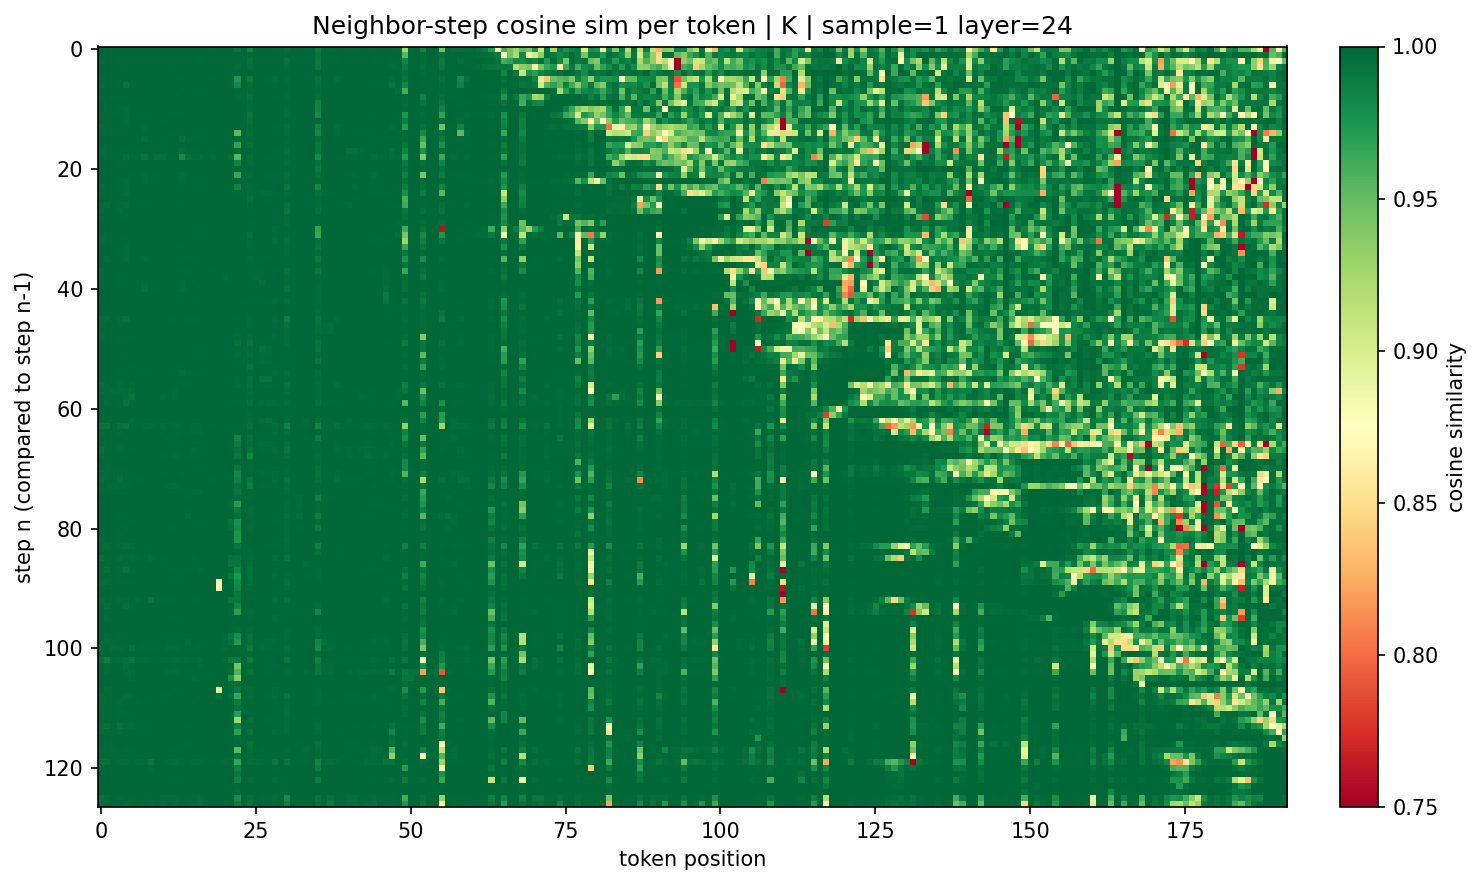

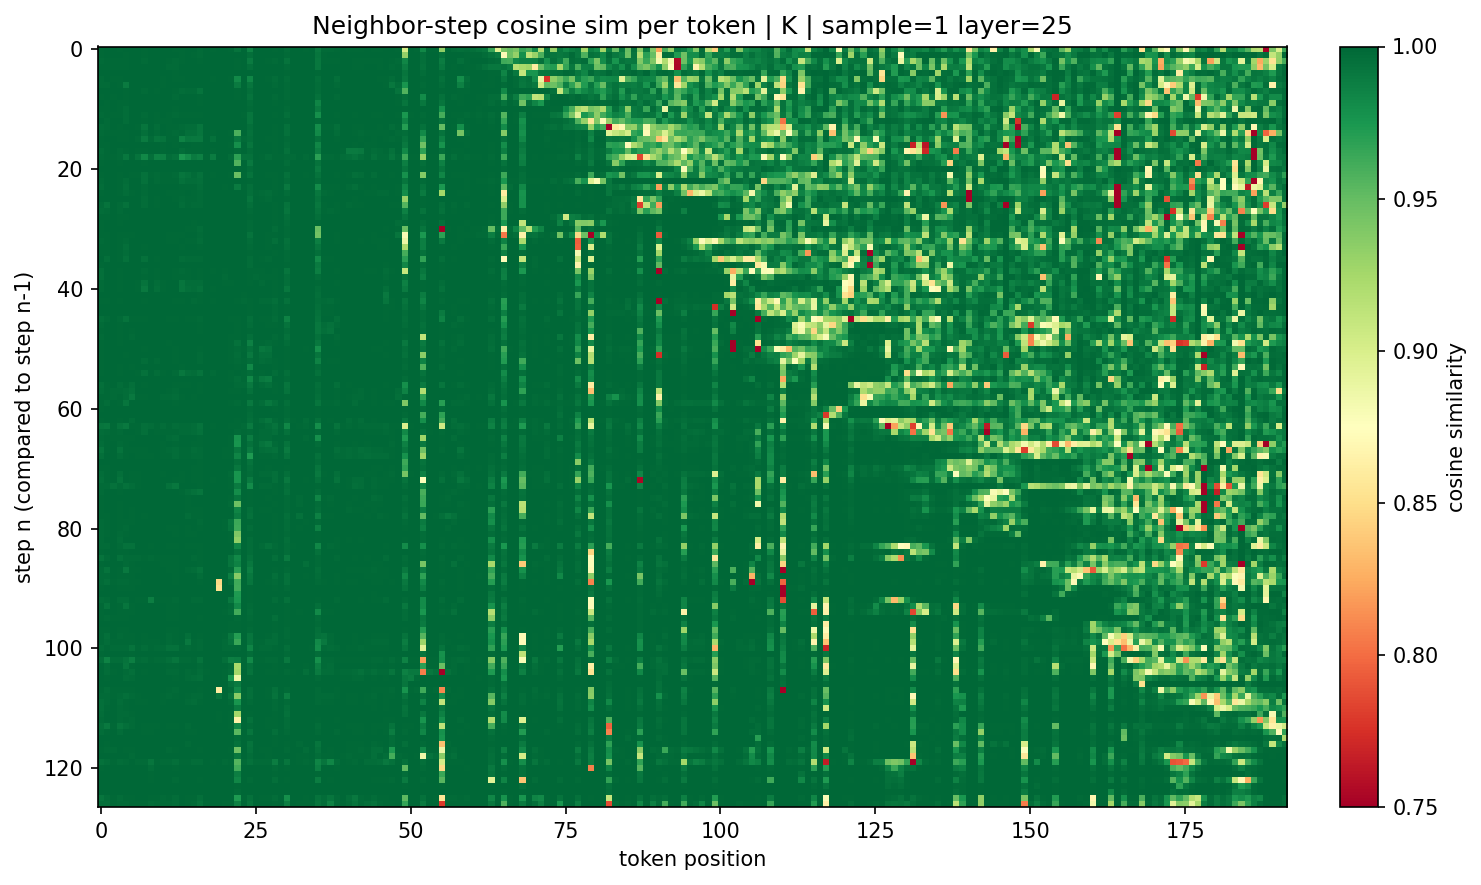

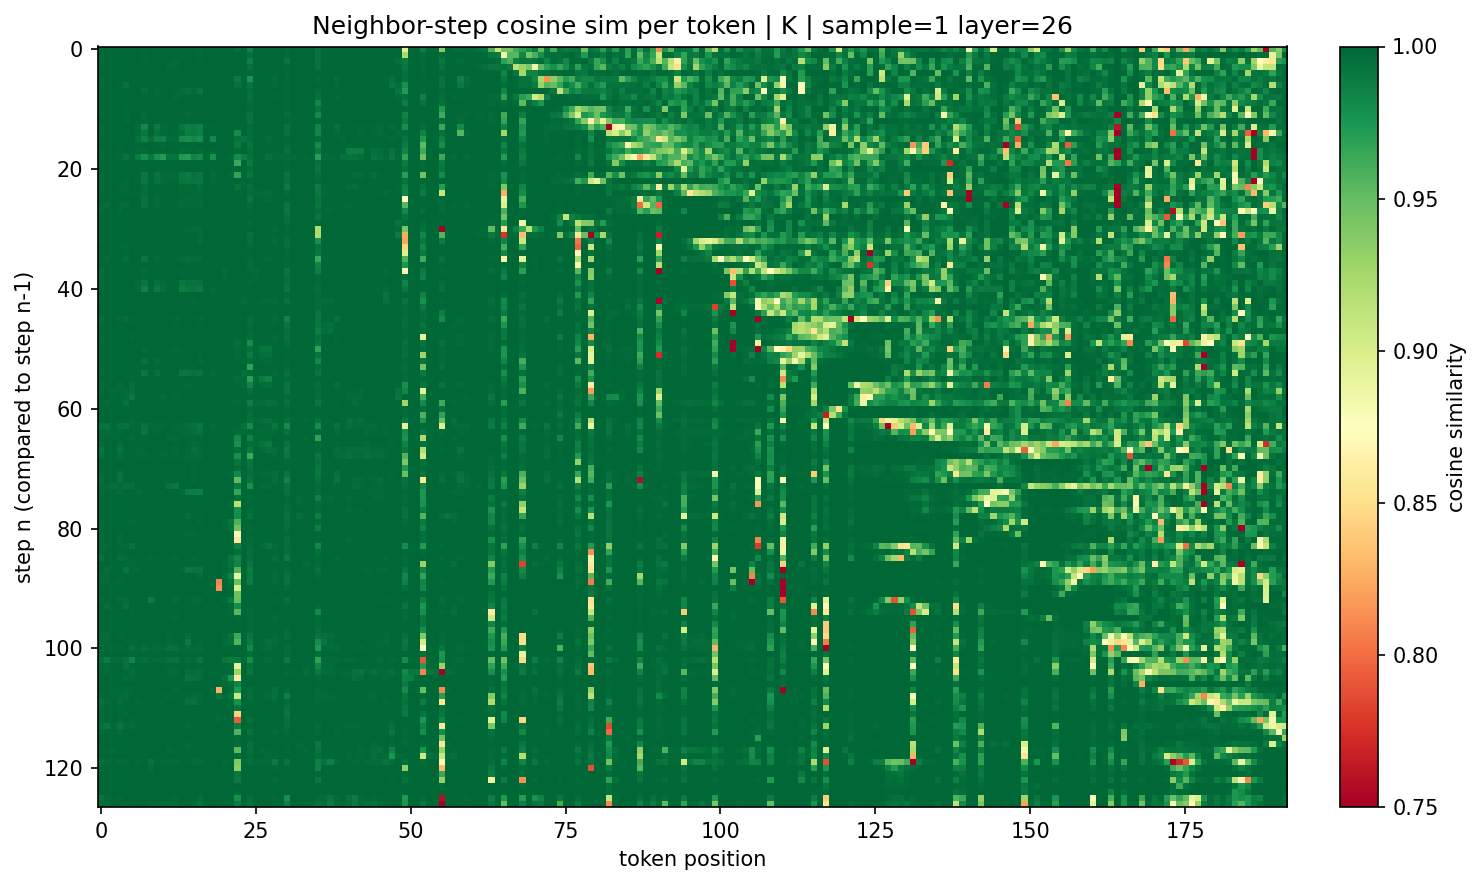

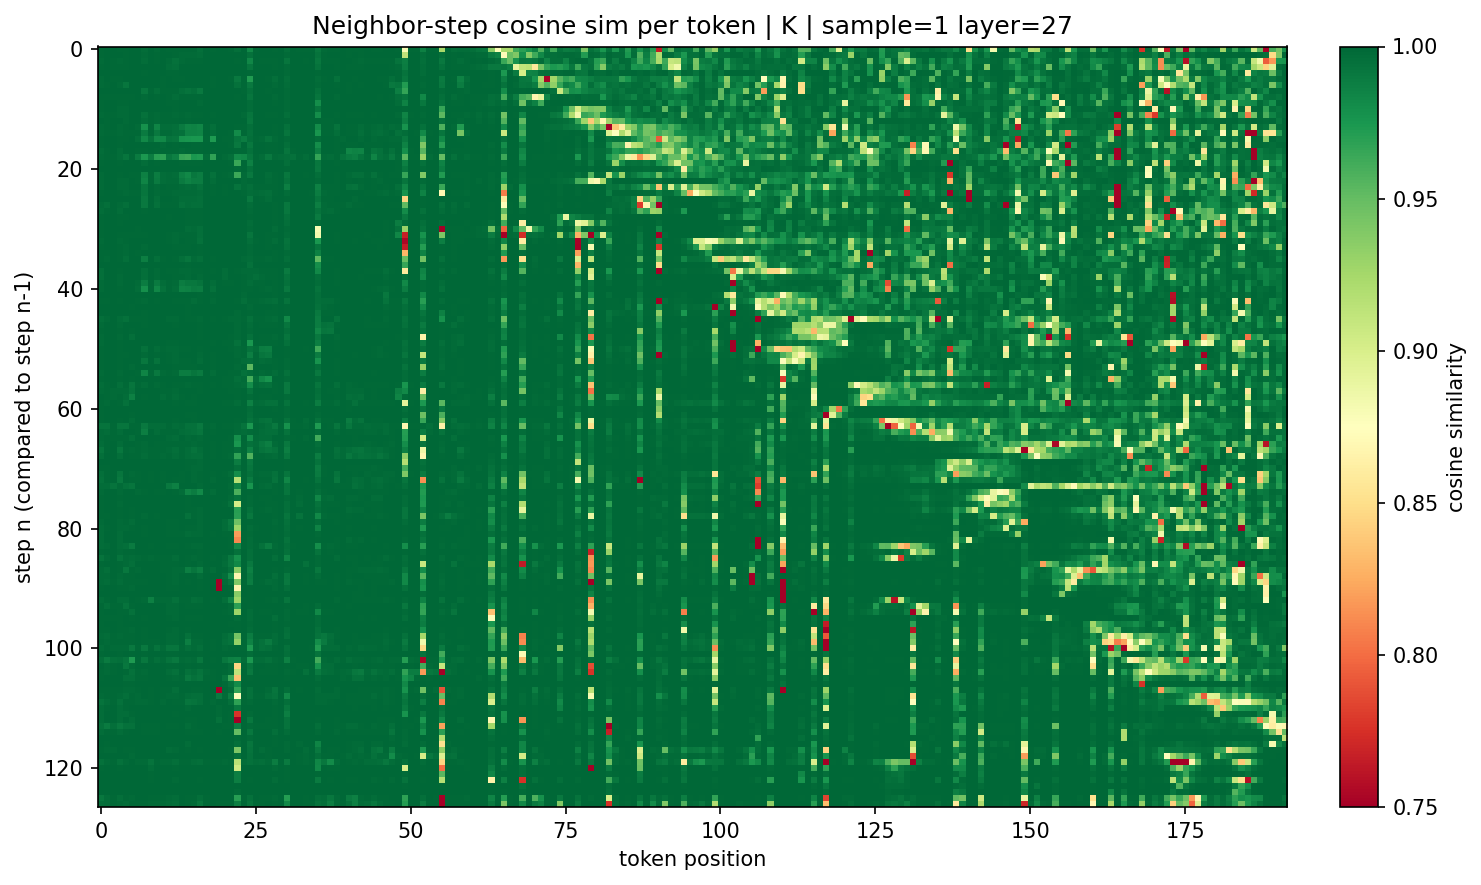

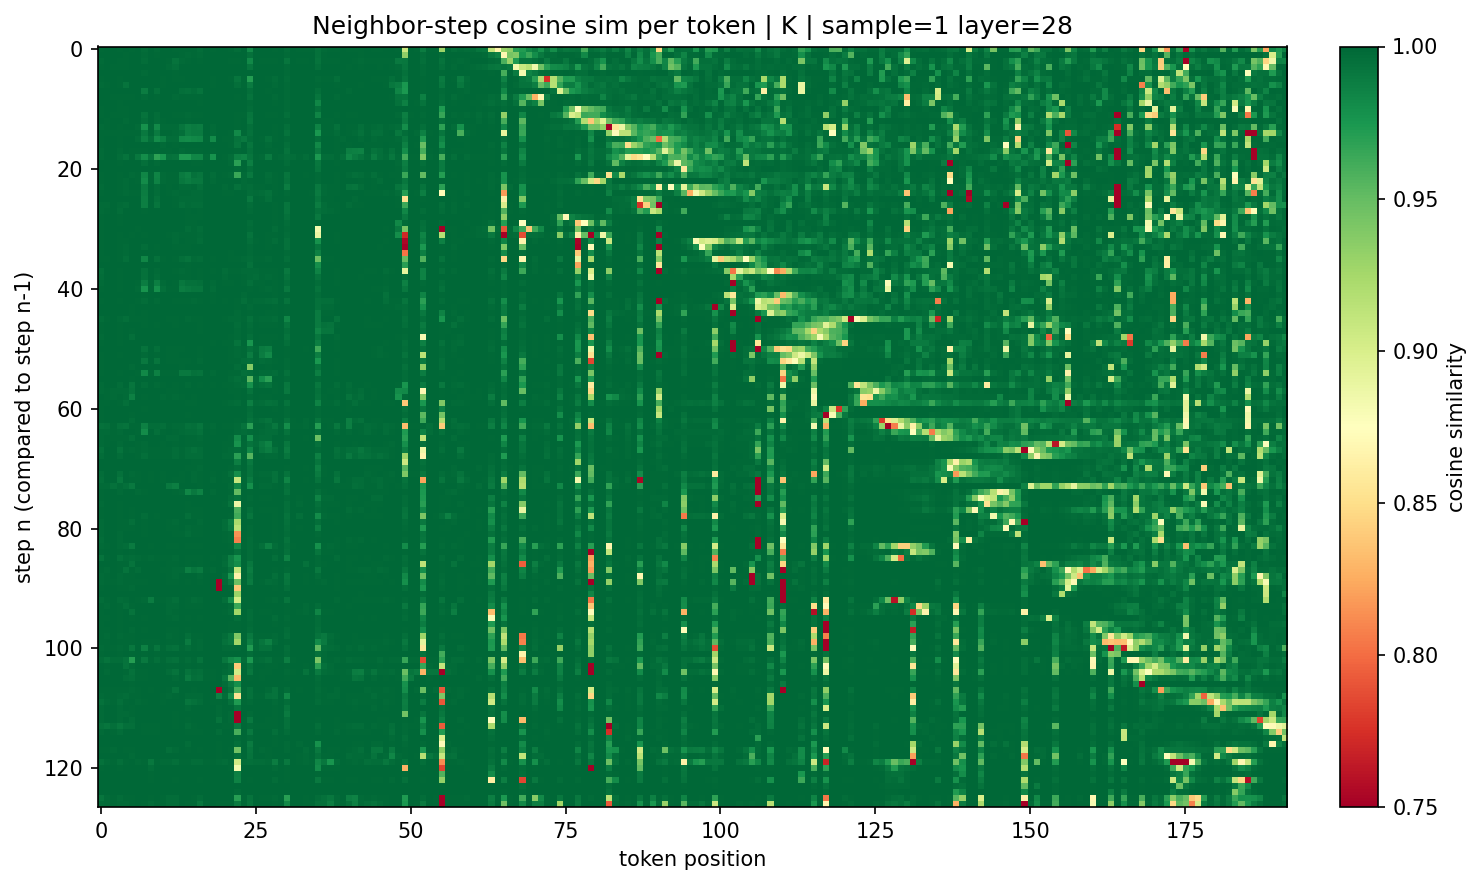

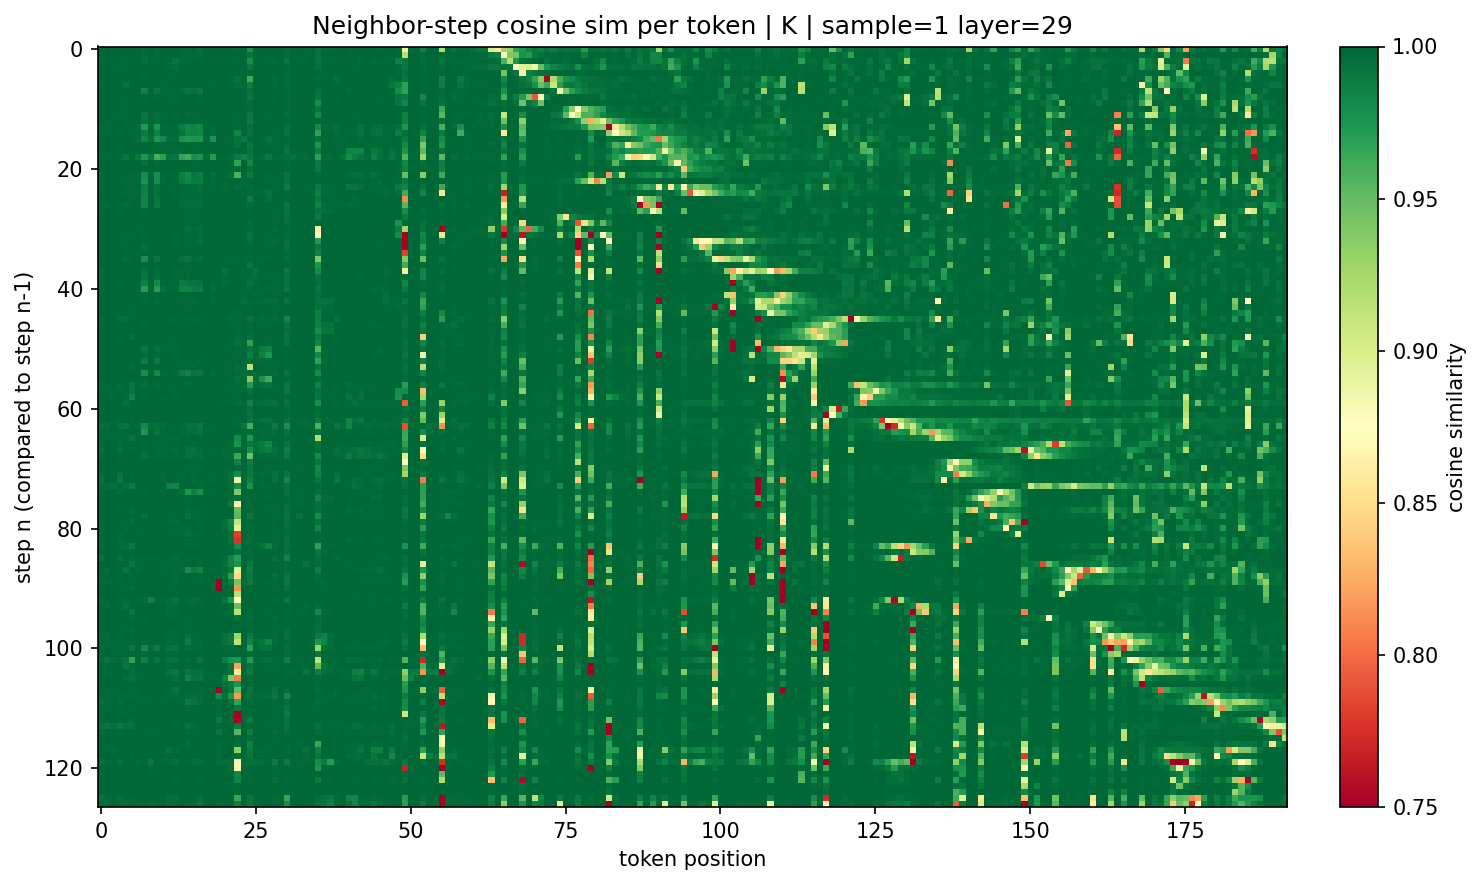

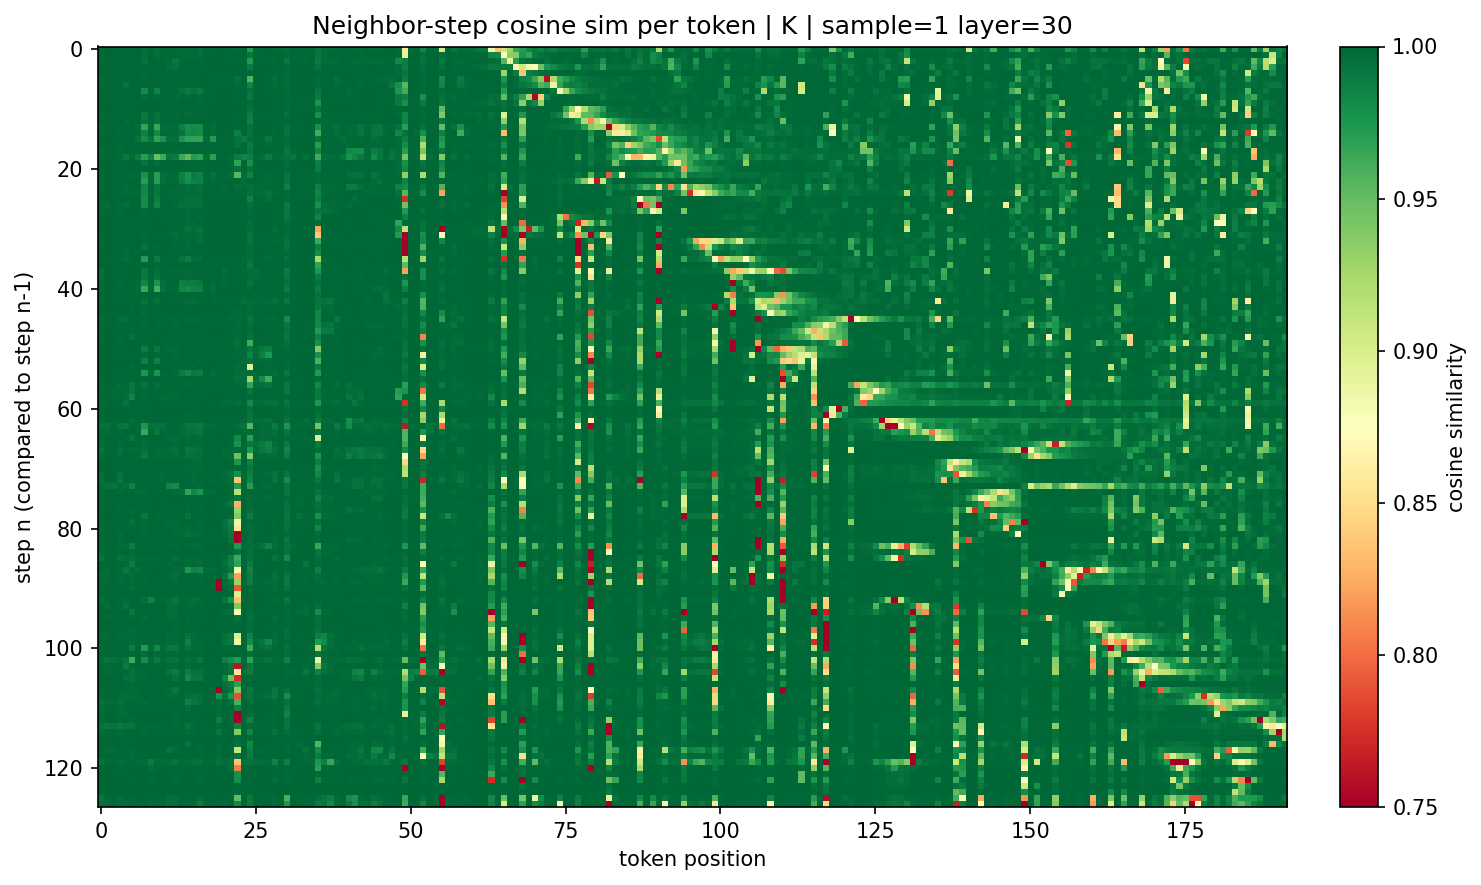

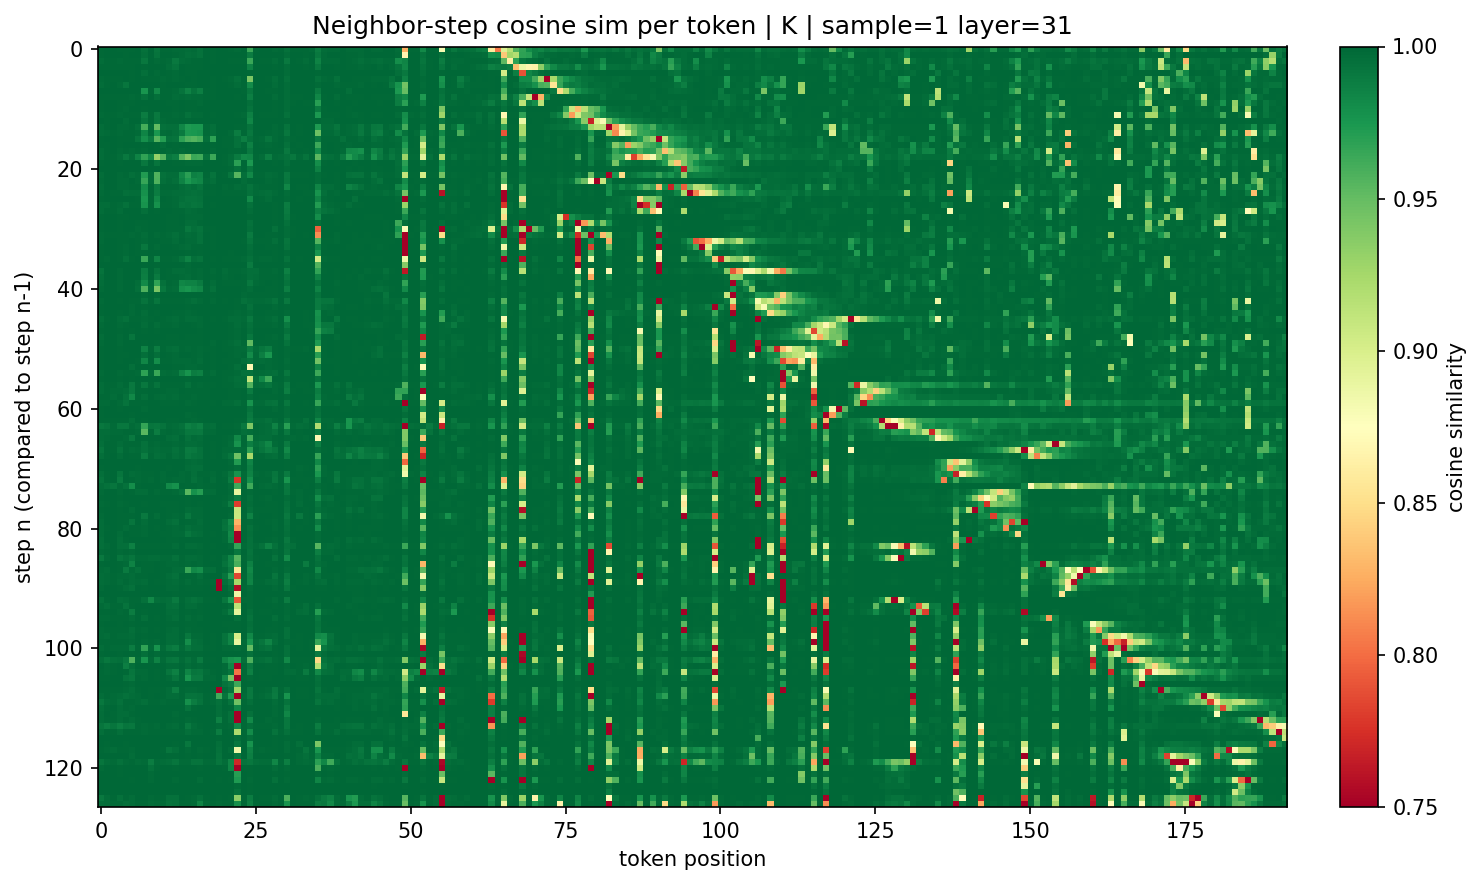

In [5]:
# ---- usage ----
records_dir = "kv_states_20260219_consistency"
sample_id = 1
kind = "k"  # or "v"

sims_layers = []

for layer in range(0,32):

    sims = neighbor_step_similarity_heatmap(
        records_dir=records_dir,
        sample_id=sample_id,
        layer=layer,
        kind=kind,
        total_steps=128,
        block_size=32,
        block_id_base=0,   # matches your example naming
    )

    plot_token_vs_neighborstep_heatmap(
        sims,
        title=f"Neighbor-step cosine sim per token | {kind.upper()} | sample={sample_id} layer={layer}",
        savepath=f"neighborstep_{kind}_b{sample_id}_l{layer}.png",
        vmin=0.75, vmax=1.0
    )

    sims_layers.append(sims)
# end


In [ ]:
tensors_sims_layers = torch.stack(sims_layers, dim=0)   # 32, 127, 192
tensors_sims_layers_selected = tensors_sims_layers[:,60:, :110]  # 32, 67, 110

torch.Size([32, 67, 110])

In [ ]:
sum_change_layer = torch.sum(tensors_sims_layers_selected, dim=1)   # 32, 110
sum_change_layer_normed = (tensors_sims_layers_selected.shape[1] - sum_change_layer).abs()

In [79]:
for idx_layer, layer_idx_argsort in enumerate(torch.argsort(sum_change_layer_normed,-1).numpy().tolist()):
    # print(' '.join([f'{str(idx_argsort)}:{sum_change_layer_normed[idx_layer, idx_argsort]/tensors_sims_layers.shape[1]}' for idx_argsort in sorted(layer_idx_argsort[:15])  ]))
    print(' '.join([f'{str(idx_argsort)}' for idx_argsort in sorted(layer_idx_argsort[:15])  ]))
# end

3 16 21 34 35 54 55 79 80 81 83 84 87 92 94
9 11 26 28 49 51 53 58 60 69 73 74 80 96 106
0 6 10 15 16 22 24 28 29 43 47 50 51 58 73
19 20 21 22 24 25 26 27 28 29 30 46 50 73 105
7 9 16 19 20 21 22 24 25 26 28 29 30 46 73
19 21 22 24 25 27 28 29 30 39 50 62 73 75 76
19 24 25 28 29 30 39 40 46 62 67 69 73 75 76
19 20 25 29 31 39 60 61 62 64 69 73 76 80 88
19 29 31 34 39 40 60 62 64 67 69 73 75 76 80
19 23 29 31 34 39 40 60 61 62 69 73 76 80 92
19 20 22 23 25 29 31 37 60 61 69 73 76 80 92
9 16 19 20 22 23 25 29 31 39 60 62 69 73 80
16 19 20 21 22 23 25 26 29 31 60 69 73 80 81
9 20 23 25 31 39 60 61 66 69 73 80 81 88 92
23 26 29 31 39 60 69 73 76 80 81 86 88 92 93
23 31 39 60 61 69 73 75 80 81 86 88 92 93 101
23 26 31 61 64 69 75 80 81 86 88 92 101 104 109
23 31 60 61 64 66 69 75 80 81 86 88 92 101 104
18 23 31 39 64 69 73 75 80 81 86 88 100 101 104
17 18 23 29 31 61 64 69 73 75 80 81 86 88 101
17 18 23 29 31 61 64 69 73 75 80 81 86 88 101
17 18 23 29 31 60 61 64 69 75 80 81 86 88 101
17 1

In [74]:
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def plot_change_rate_heatmap(change_rate_2d: torch.Tensor, title="Accumulated change rate", vmin=0, vmax=0.1):
    """
    change_rate_2d: torch.Tensor of shape (num_layers, seq_len)
        y-axis: layer index (0..num_layers-1)
        x-axis: token position (0..seq_len-1)
        values: accumulated change rate
    """
    if not torch.is_tensor(change_rate_2d):
        change_rate_2d = torch.tensor(change_rate_2d)

    # move to cpu for plotting
    data = change_rate_2d.detach().float().cpu().numpy()
    cmap = LinearSegmentedColormap.from_list("green_to_red", ["green", "red"])

    num_layers, seq_len = data.shape

    plt.figure(figsize=(12, 5))
    im = plt.imshow(
        data,
        aspect="auto",
        origin="lower",   # layer 0 at the bottom; use "upper" if you prefer
        vmin=vmin,
        vmax=vmax,
        cmap=cmap
    )
    plt.colorbar(im, label="accumulated change rate")

    plt.xlabel("token position")
    plt.ylabel("layer")
    plt.title(title)

    # nicer ticks (avoid overcrowding)
    xticks = list(range(0, seq_len, max(1, seq_len // 16)))
    yticks = list(range(0, num_layers, max(1, num_layers // 12)))
    plt.xticks(xticks)
    plt.yticks(yticks)

    plt.tight_layout()
    plt.show()


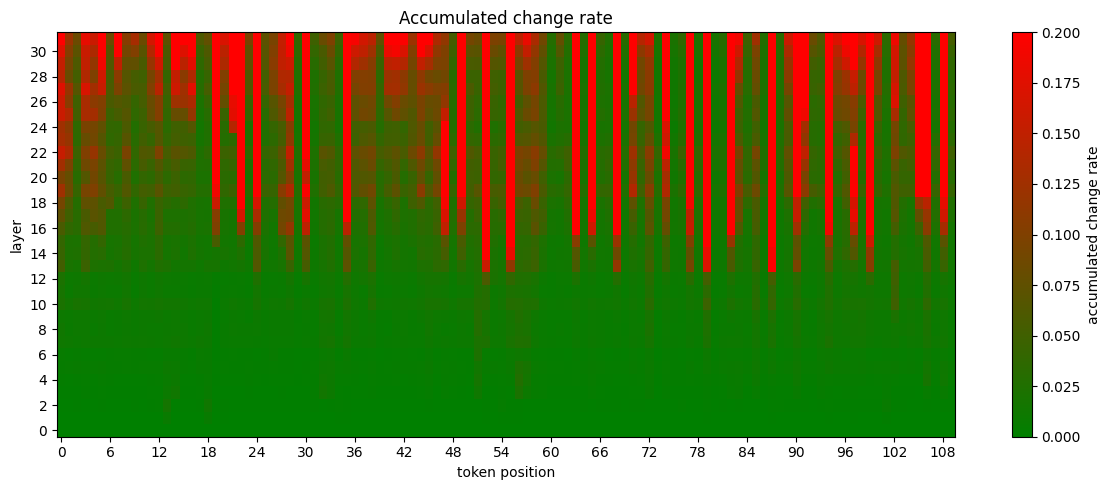

In [78]:
plot_change_rate_heatmap(sum_change_layer_normed, vmax=0.2)